# DES simulation of queues at high load

This notebook contains the code used to generate the data and plots for parts 2-4 of the assignment.

In [1]:
import random
import simpy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from os.path import exists
from os import mkdir
from scipy.interpolate import interp1d
from math import factorial
import seaborn as sns
import pandas as pd
from scipy import stats

from assignment_analytical import *
from assignment_util import *
from assignment_queue import *

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11

#plt.rc("text", usetex=True)
# plt.rc("text.latex", preamble=r"""
# \usepackage{palatino}
# \usepackage{newpxmath}""")
#plt.rc("font", family="serif")


SAVEDIR = "save_data"
PLOTDIR = "plots"

DIRS = [SAVEDIR, PLOTDIR]

def savepath(filename):
    return SAVEDIR + f"/{filename}"

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)

In [2]:
def compute_difference(values):
    """
    Returns difference the last element of the array
    and the individual elements of the array.
    """
    
    i = [c for c in values]
    max_value = i[-1]

    return np.abs(i - max_value)



def dashed_heading(text, length):
    """
    "Pretty" printing headings flanked by dashes.
    """
    
    dash_length = max(length - len(text), 0)
    ldash_length = dash_length // 2
    rdash_length = dash_length - ldash_length
    ldash = "-" * ldash_length
    rdash = "-" * rdash_length
    return ldash + text + rdash



def f_test(x, y):
    """
    Fisher's F-test for comparing sample variances of two distributions.
    Assumes both distributions are normal (or at least approximately normal)
    
    Returns
    -------
        f: float
            f-statistic, ratio of larger sample variance to the smaller one
        p: p-value
    """
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    
    return f, p

In [3]:
"""
Preliminary simulation: Varying ρ-values for M/M/1, 100 runs.
"""

random.seed(0x101ca7)
SIM_TIME = 10**5
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[1:10]
number_of_runs = 100
λ_values = ρ_values * μ

N = len(ρ_values)

waiting_times = np.zeros((N, number_of_runs))

server_count = 1
service_t_dist = exp_factory(μ)

filename = "different_rhos_refactor.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i,ρ in enumerate(ρ_values):
        print(f"===ρ={ρ}===")
        for run in range(number_of_runs):
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, server_count, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            
            waiting_times[i][run] = np.mean(system.ts_waiting)
        
    np.savez(filepath, waiting_times)
    
else:
    save_data = np.load(filepath)
    waiting_times = save_data['arr_0']

In [4]:
def rhos_plotter(simulation_data, title):
    """ 
    Plots estimated mean waiting time for different ρ-values together with 
    analytical mean waiting time for given ρ-values.
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    wt_means = []
    wt_variance = []
    
    for i in data:
        mean, variance = sample_mean_variance(i)
        wt_means.append(mean)
        wt_variance.append(variance)
        
    std = np.sqrt(wt_variance) 
    
    n = 100 # number of runs
    
    μ = 1.0
    ρ_values = np.linspace(0, 1, 11)[1:10]
    λ_values = ρ_values * μ
    
    # For plotting analytical estimate
    analytical_waiting_times = np.zeros(len(ρ_values))
    for i,ρ in enumerate(ρ_values):
        λ = μ * ρ
        analytical_waiting_times[i] = MM1_waiting_time(λ, μ)
    
    print("Analytical waiting times for ρ = 0.5: " + str(analytical_waiting_times[4]))
    print("Analytical waiting times for ρ = 0.6: {0:.2f} ".format(analytical_waiting_times[5]))
    print("Analytical waiting times for ρ = 0.7: {0:.2f} ".format(analytical_waiting_times[6]))
    print("Analytical waiting times for ρ = 0.8: {0:.2f} ".format(analytical_waiting_times[7]))
    print("Analytical waiting times for ρ = 0.9: {0:.2f} ".format(analytical_waiting_times[8]))
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(wt_variance)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) ρ = 0.5: {0:4f} ± {1:4f}".format(wt_means[4], conf_95[4]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.6: {0:4f} ± {1:4f}".format(wt_means[5], conf_95[5]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.7: {0:4f} ± {1:4f}".format(wt_means[6], conf_95[6]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.8: {0:4f} ± {1:4f}".format(wt_means[7], conf_95[7]))
    
    print("Mean waiting time ± CI (95%) ρ = 0.9: {0:4f} ± {1:4f}".format(wt_means[8], conf_95[8]))
    
    plt.plot(ρ_values, wt_means, alpha = 0.5, marker = "h", color = "maroon", label = "simulated: 100 runs")
    plt.plot(ρ_values, analytical_waiting_times, alpha = 0.5, marker = "d", markersize = 3, linestyle = "--", color = "black", label = "analytical")
    plt.fill_between(ρ_values, wt_means - std, wt_means + std, alpha = 0.3, color = 'maroon')
    plt.legend()
    plt.grid()
    plt.xlabel("System load, ρ")
    
    plt.ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$ and SD")
    
    title = plot_savepath(title)
    plt.savefig(title)
    plt.show()

Analytical waiting times for ρ = 0.5: 1.0
Analytical waiting times for ρ = 0.6: 1.50 
Analytical waiting times for ρ = 0.7: 2.33 
Analytical waiting times for ρ = 0.8: 4.00 
Analytical waiting times for ρ = 0.9: 9.00 
Mean waiting time ± CI (95%) ρ = 0.5: 0.999217 ± 0.004935
Mean waiting time ± CI (95%) ρ = 0.6: 1.497590 ± 0.006556
Mean waiting time ± CI (95%) ρ = 0.7: 2.328624 ± 0.013401
Mean waiting time ± CI (95%) ρ = 0.8: 3.997041 ± 0.031576
Mean waiting time ± CI (95%) ρ = 0.9: 8.925302 ± 0.128993


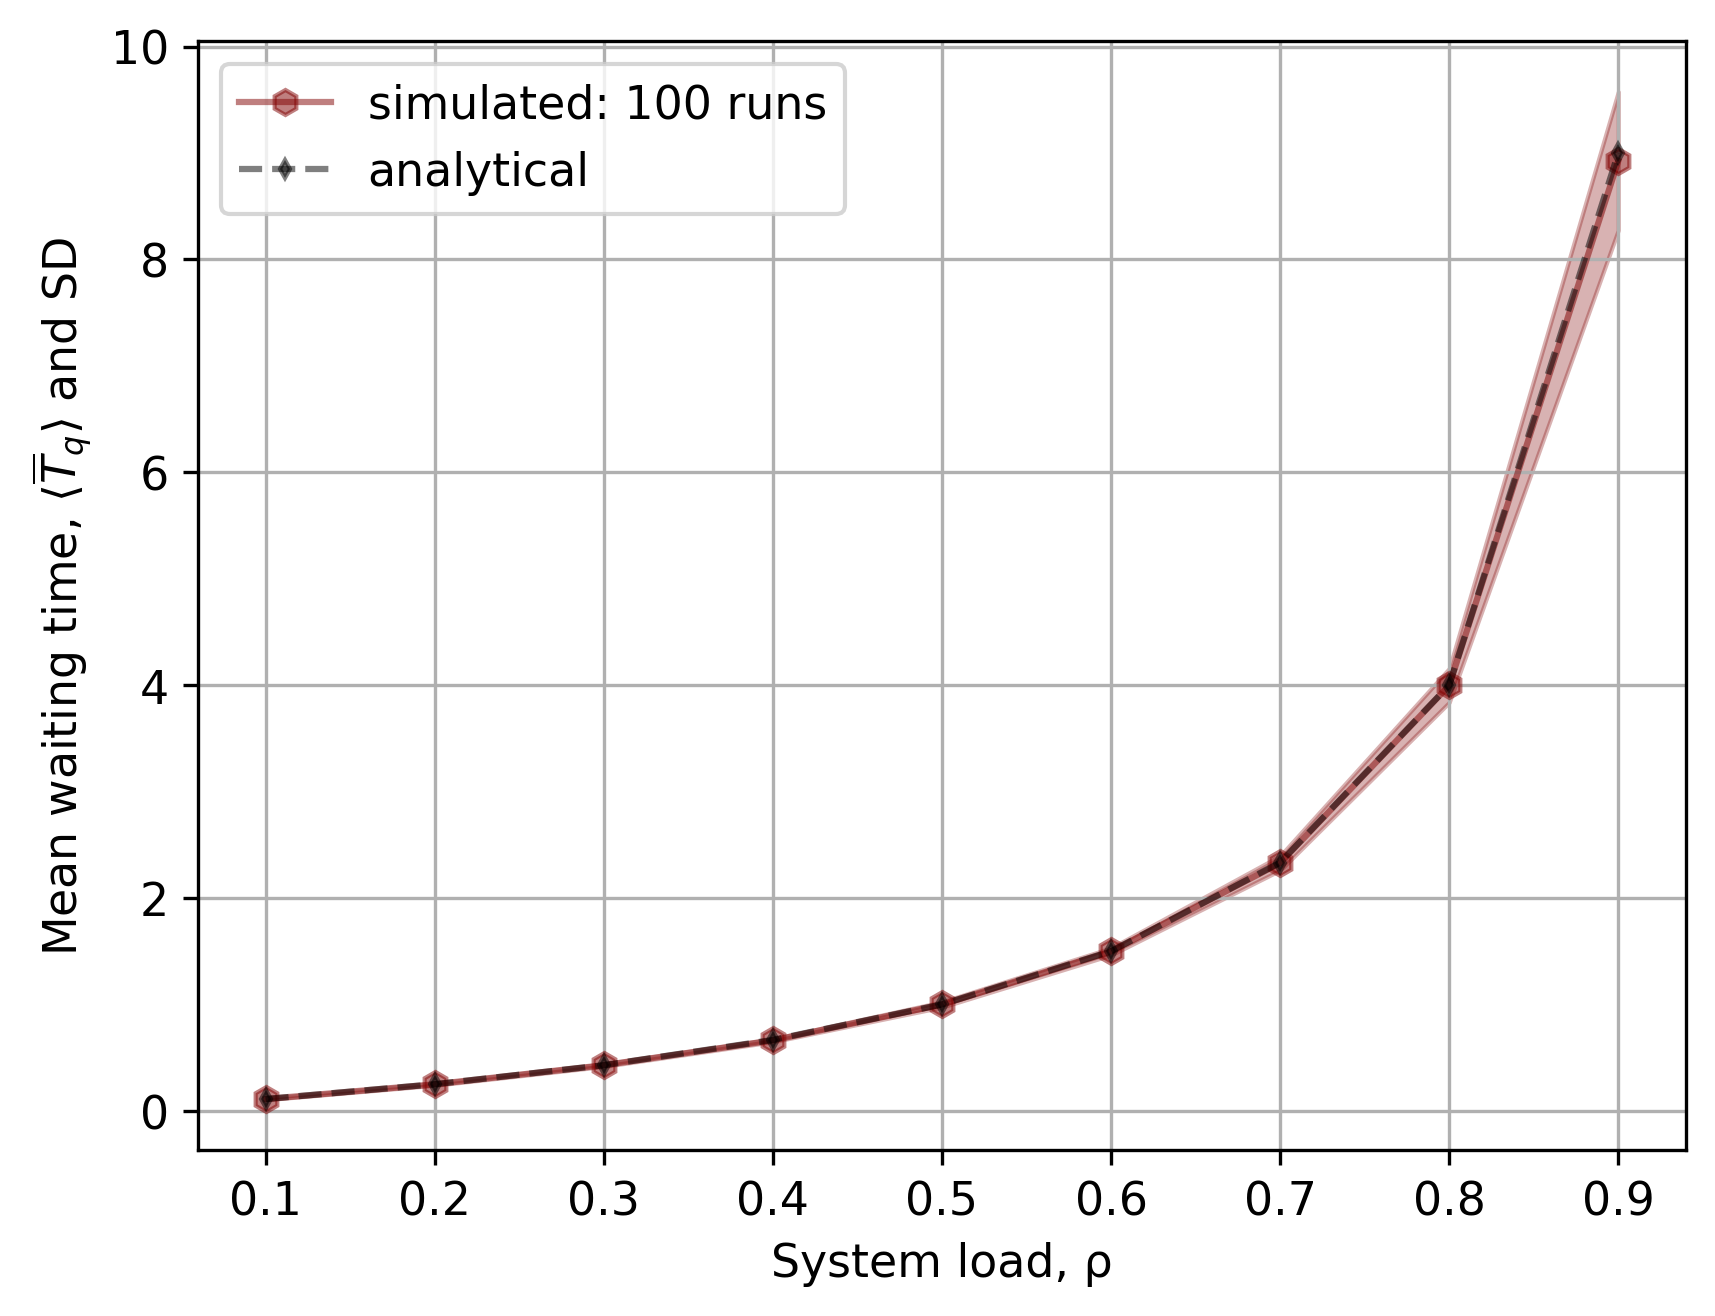

In [5]:
#rhos_plotter("different_rhos_refactor.npz", "different_rhos_refactor.png")
#Saving as pdf
rhos_plotter("different_rhos_refactor.npz", "different_rhos_refactor.pdf")

In [6]:
"""
Preliminary simulation: Transient to steady-state (varying simulation time) 
for ρ-values: 0.5, 0.6, 0.7, 0.8, 0.9.
"""

simulation_times = np.logspace(2, 6, num = 5, base = 10)
# server_counts = np.array([1,2,4])
μ = 1.0
ρ_values = np.linspace(0, 1, 11)[5:-1]
number_of_runs = 20

service_t_dist = exp_factory(μ)

# n1 = len(server_counts)
n2 = len(ρ_values)
n3 = len(simulation_times)

mean_waiting_times = np.zeros((n2, n3))
svar_waiting_times = np.zeros((n2, n3))

filename = "transient_to_SS.npz"
filepath = savepath(filename)


if not exists(filepath):
    for j, ρ in enumerate(ρ_values):
        print(f"ρ = {ρ}")
        λ = μ * ρ
        interarrival_t_dist = exp_factory(λ)
        for k, T in enumerate(simulation_times):
            print(f"Simulation time = {T}")
            batch_means = np.zeros(number_of_runs)
            for l in range(number_of_runs):
                env = simpy.Environment()
                system = System(env, 1, service_t_dist)
                system.env.process(sim_setup(system, interarrival_t_dist))
                system.env.run(until = T)
                batch_means[l] = np.mean(system.ts_waiting)
            smean, svar = sample_mean_variance(batch_means)
            mean_waiting_times[j][k] = smean
            svar_waiting_times[j][k] = svar
    np.savez(filepath, mean_waiting_times, svar_waiting_times)
else:
    save_data = np.load(filepath)
    mean_waiting_times = save_data['arr_0']
    svar_waiting_times = save_data['arr_1']

In [7]:
def varying_sim_time_plotter(simulation_data, title, rho):
    """
    Plots mean waiting time and confidence intervals accross simulated times for
    different ρ-values.
    """

    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)
    
    mean_waiting_times = data['arr_0']
    svar_waiting_times = data['arr_1']
    
    μ = 1.0
    ρ_values = np.linspace(0, 1, 11)[5:-1]
    λ_values = ρ_values * μ
    
    # For plotting analytical estimate
    analytical_waiting_times = np.zeros(len(ρ_values))
    for i,ρ in enumerate(ρ_values):
        λ = μ * ρ
        analytical_waiting_times[i] = MM1_waiting_time(λ, μ)

    
    if rho == 0.5:
        mean = mean_waiting_times[0]
        svar = svar_waiting_times[0]
        analytical_wt = analytical_waiting_times[0]

    elif rho == 0.6:
        mean = mean_waiting_times[1]
        svar = svar_waiting_times[1]
        analytical_wt = analytical_waiting_times[1]

    elif rho == 0.7:
        mean = mean_waiting_times[2]
        svar = svar_waiting_times[2]
        analytical_wt = analytical_waiting_times[2]
        
    elif rho == 0.8:
        mean = mean_waiting_times[3]
        svar = svar_waiting_times[3]
        analytical_wt = analytical_waiting_times[3]
    
    elif rho == 0.9:
        mean = mean_waiting_times[4]
        svar = svar_waiting_times[4]
        analytical_wt = analytical_waiting_times[4]
    
    
    simulation_times = np.logspace(2, 6, num = 5, base = 10)
    std = np.sqrt(svar) 

    n = 20 # number of runs
    
    conf_95 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(svar)/np.sqrt(n)
   
    difference = compute_difference(values = conf_95)

    ax = plt.gca() 

    plt.plot(simulation_times, mean, alpha = 0.5, color = "darkred", marker = "h") # label = "$ρ = $" + str(rho))
    plt.fill_between(simulation_times, mean - conf_95, mean + conf_95, alpha = 0.3, color = "darkred")
    plt.hlines(analytical_wt, simulation_times[0], simulation_times[-1], label = "analytical ${T}_q$", linestyles="dashed", linewidth = 2, color = "darkblue", alpha = 0.7)
    
    plt.xlabel("Simulation time")
    plt.xscale('log')
    
    plt.legend()
    ax.set_ylabel(r"Mean waiting time, $\langle \overline{T}_q \rangle$ and 95% CI", color = "darkred")
    plt.grid(True)
    
    ax2 = ax.twinx()
    ax2.plot(simulation_times, difference, color = 'black', marker = "D", markersize = 4, linestyle = "-.", alpha = 0.7)
    for xitem, yitem in np.nditer([simulation_times, difference]):
        etiqueta = "{:.3f}".format(yitem)
        plt.annotate(etiqueta, (xitem, yitem), size = 11, color = "black", textcoords="offset points",xytext=(0,10),ha="center")
    ax2.tick_params(axis='y', labelcolor='black')
    if rho < 0.9:
        ax.set_ylim(0.06, 6)
        ax2.set_ylim(-0.4, 1.3)
    ax2.set_ylabel("Absolute difference in 95% CI", color = 'black')
    
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

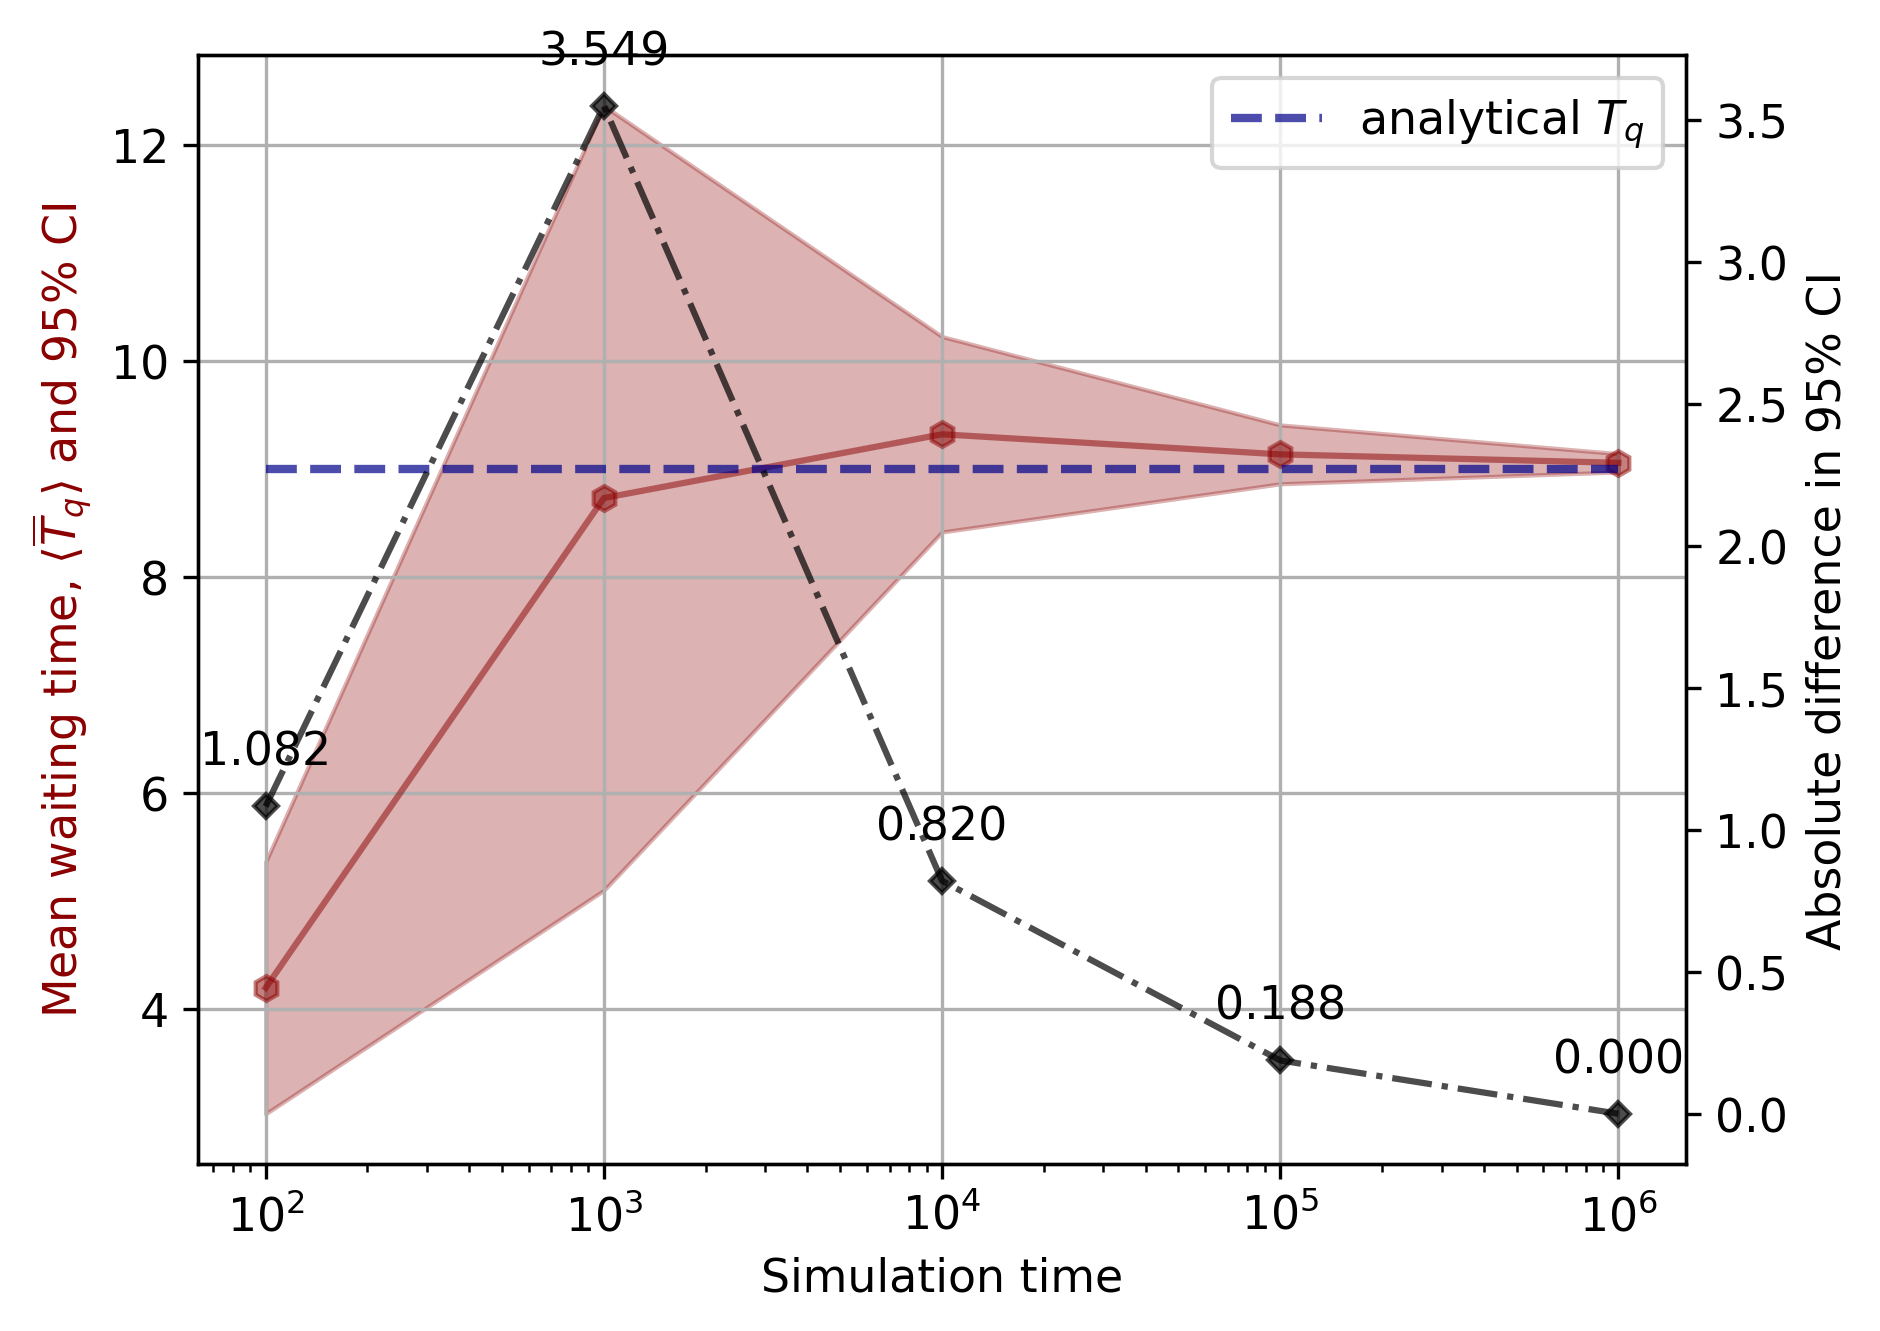

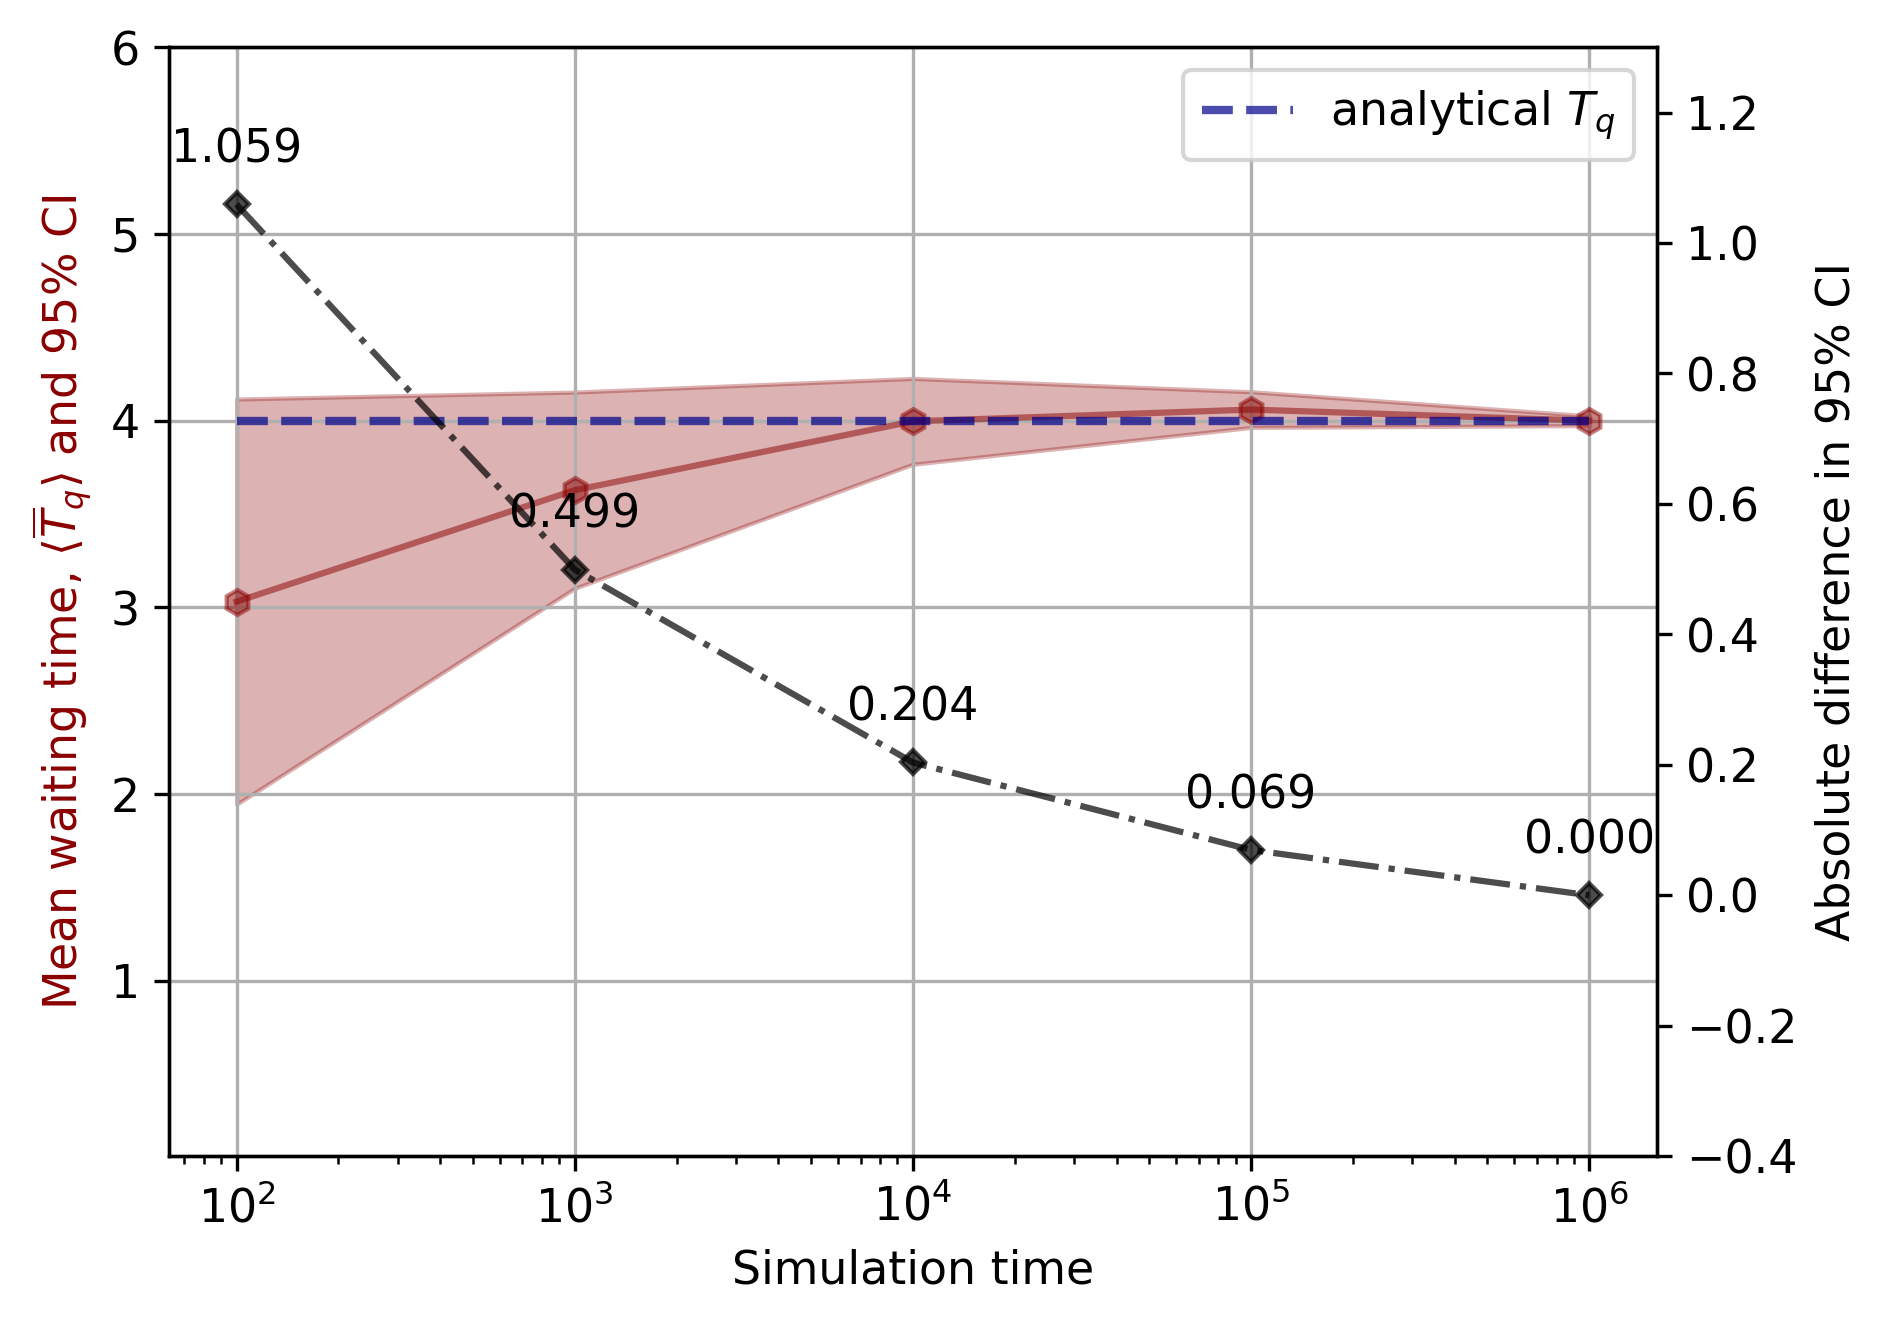

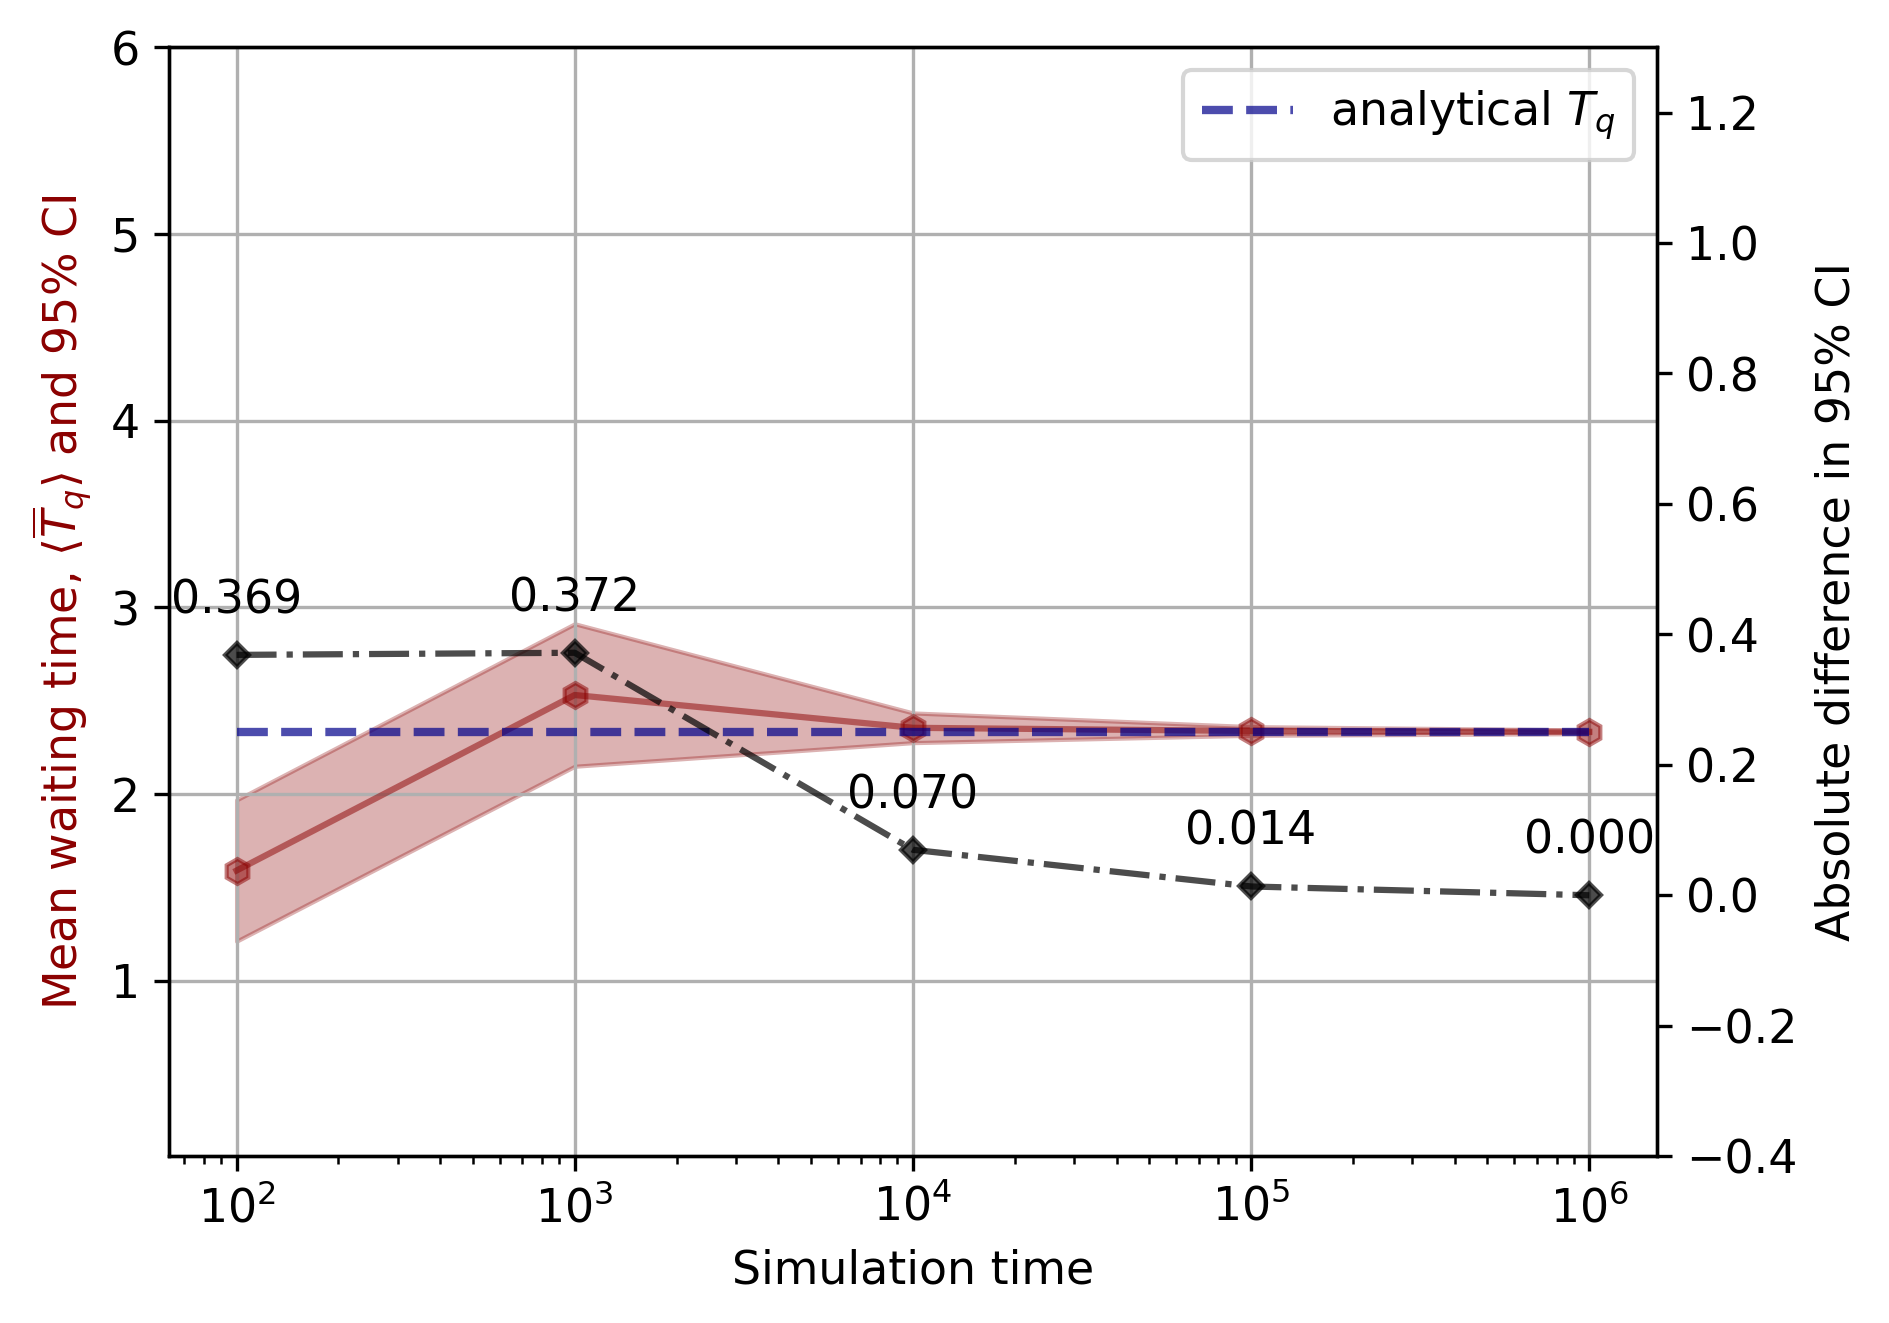

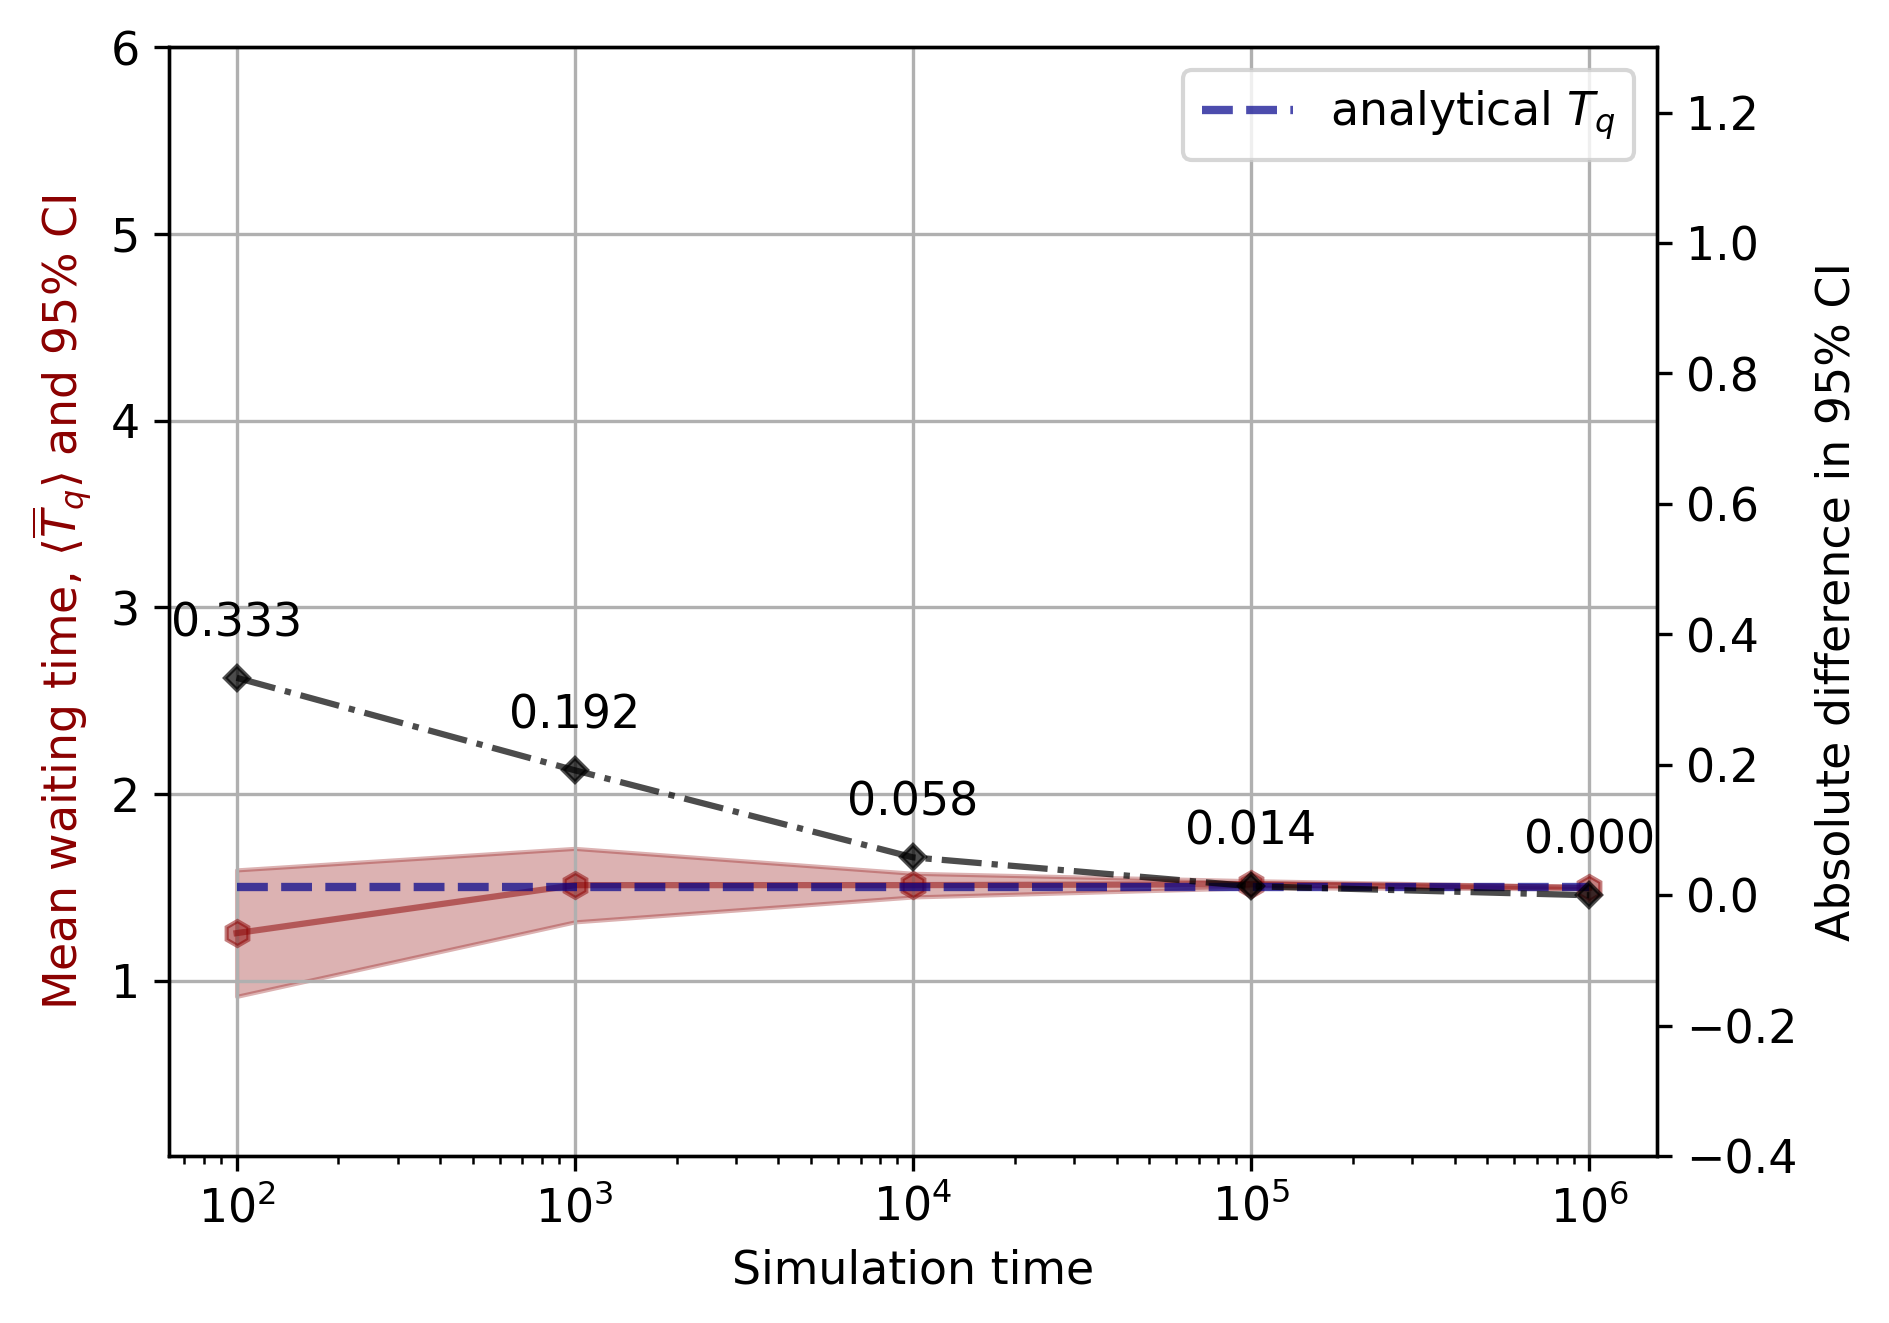

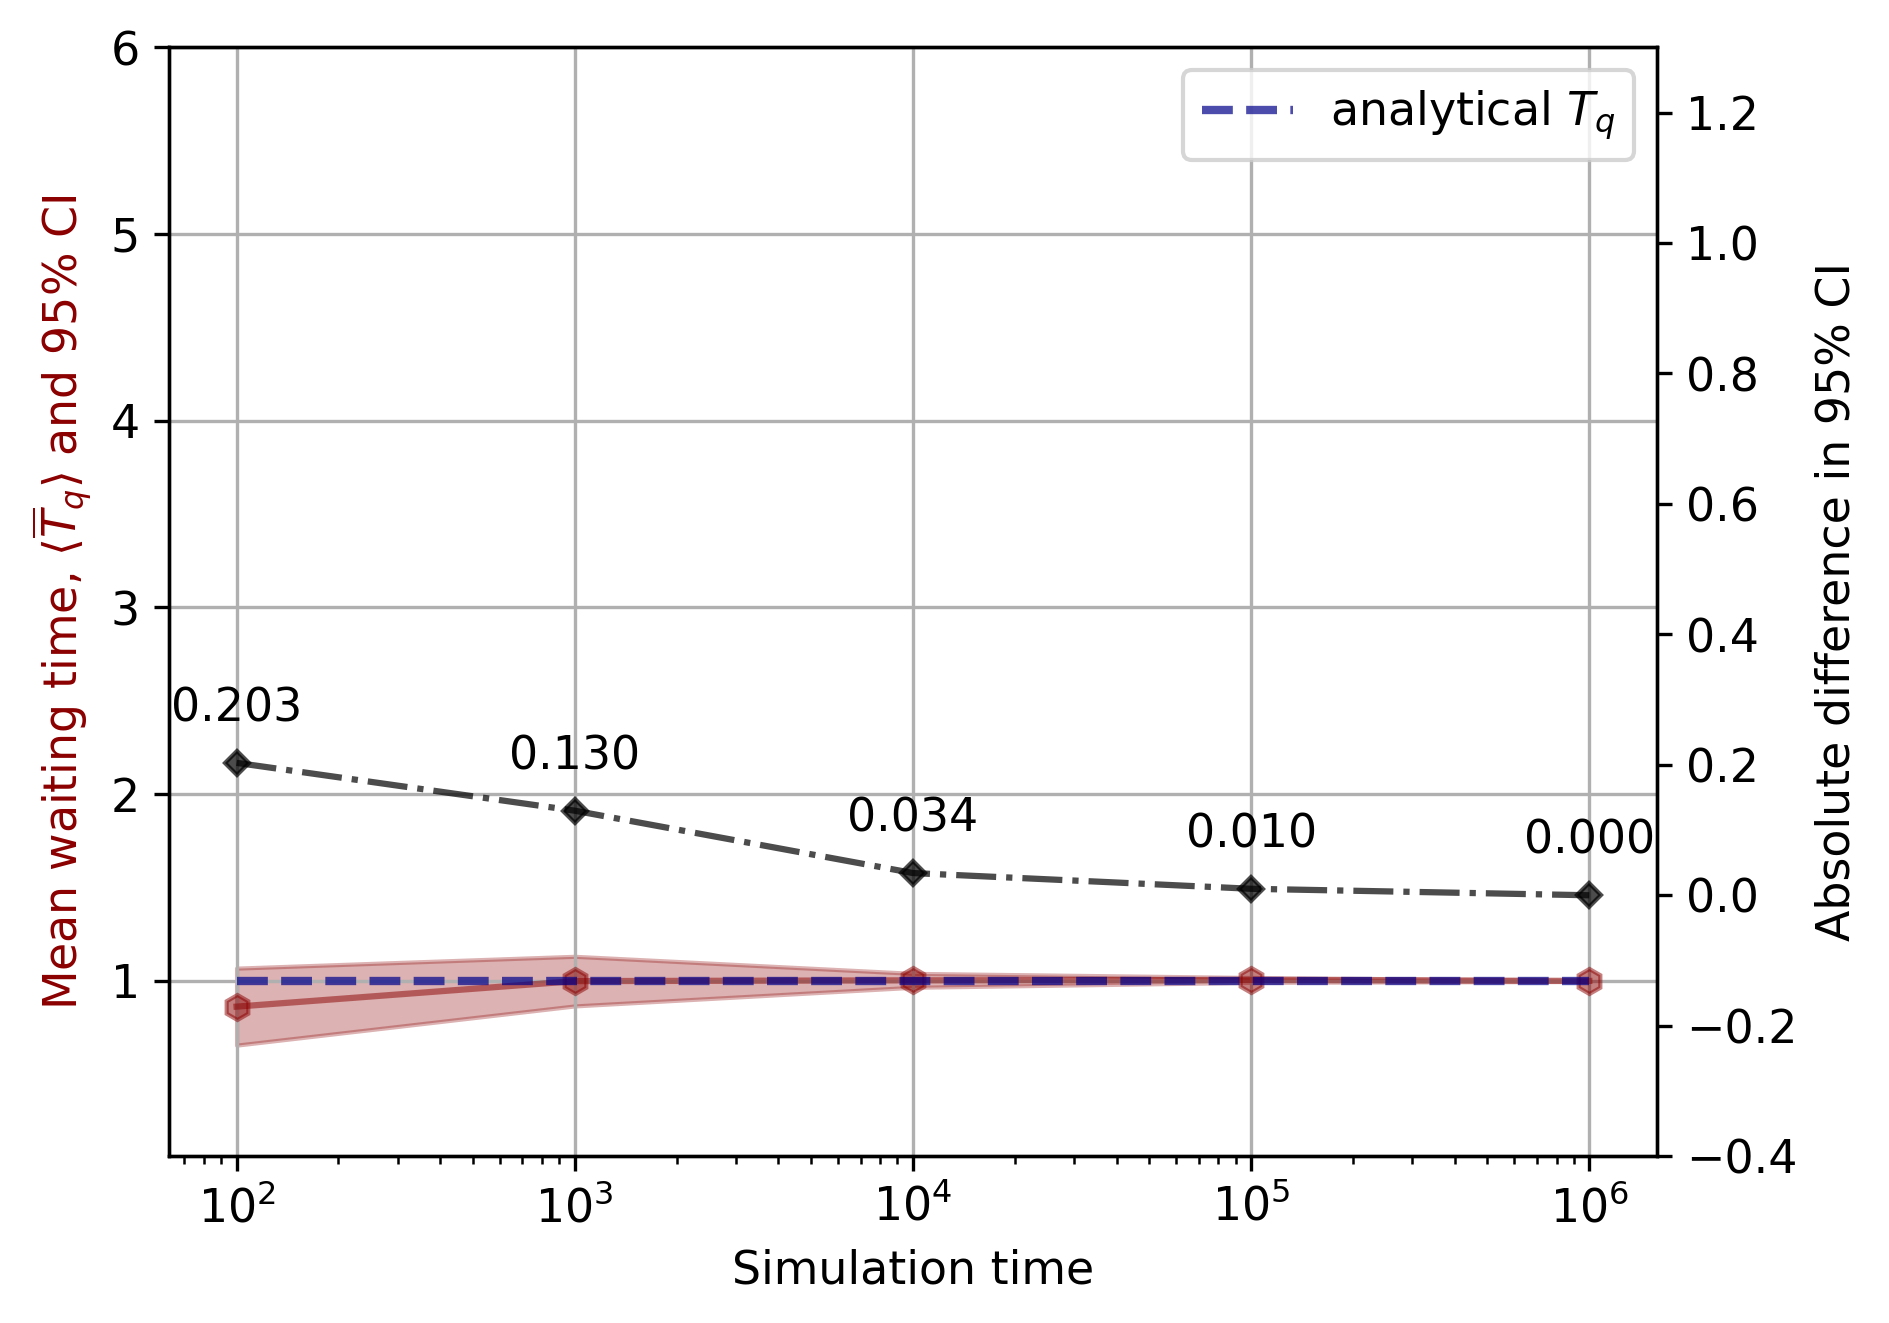

In [8]:
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_09.pdf", rho = 0.9)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_08.pdf", rho = 0.8)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_07.pdf", rho = 0.7)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_06.pdf", rho = 0.6)
varying_sim_time_plotter(simulation_data = "transient_to_SS.npz", title = "Transient_to_SS_05.pdf", rho = 0.5)

In [9]:
"""
Simulation 1: M/M/1, M/M/2, M/M/4, 100 runs.
"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = exp_factory(μ)

filename = "waiting_times_fullsave_124.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/M/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

In [10]:
def histogram_plotter(simulation_data, title):
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot` for M/M/n queues
    
    Returns mean waiting time and 95% CI
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    data = np.load(filepath)['arr_0']
    n = 100

    mean_1, variance_1 = sample_mean_variance(data[0])
    conf_95_1 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_1)/np.sqrt(n)
    
    mean_2, variance_2 = sample_mean_variance(data[1])
    conf_95_2 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_2)/np.sqrt(n)
    
    mean_4, variance_4 = sample_mean_variance(data[2])
    conf_95_4 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_4)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) for 1-server queue: {0:4f} ± {1:4f}".format(mean_1, conf_95_1))
    
    print("Mean waiting time ± CI (95%) for 2-server queue: {0:4f} ± {1:4f}".format(mean_2, conf_95_2))
    
    print("Mean waiting time ± CI (95%) for 4-server queue: {0:4f} ± {1:4f}".format(mean_4, conf_95_4))
    
    df = pd.DataFrame((data), index=["1", "2", "4"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
    fig = sns.displot(df_t, bins = 40, kde = True, legend = False, palette=palette, height=4, aspect=0.9) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $ \overline{T}_q $")
    
    plt.legend(loc = 1, title = "Number of servers (n)", labels= ["4", "2", "1"])
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()


Mean waiting time ± CI (95%) for 1-server queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for 2-server queue: 4.282069 ± 0.040814
Mean waiting time ± CI (95%) for 4-server queue: 1.964095 ± 0.015482


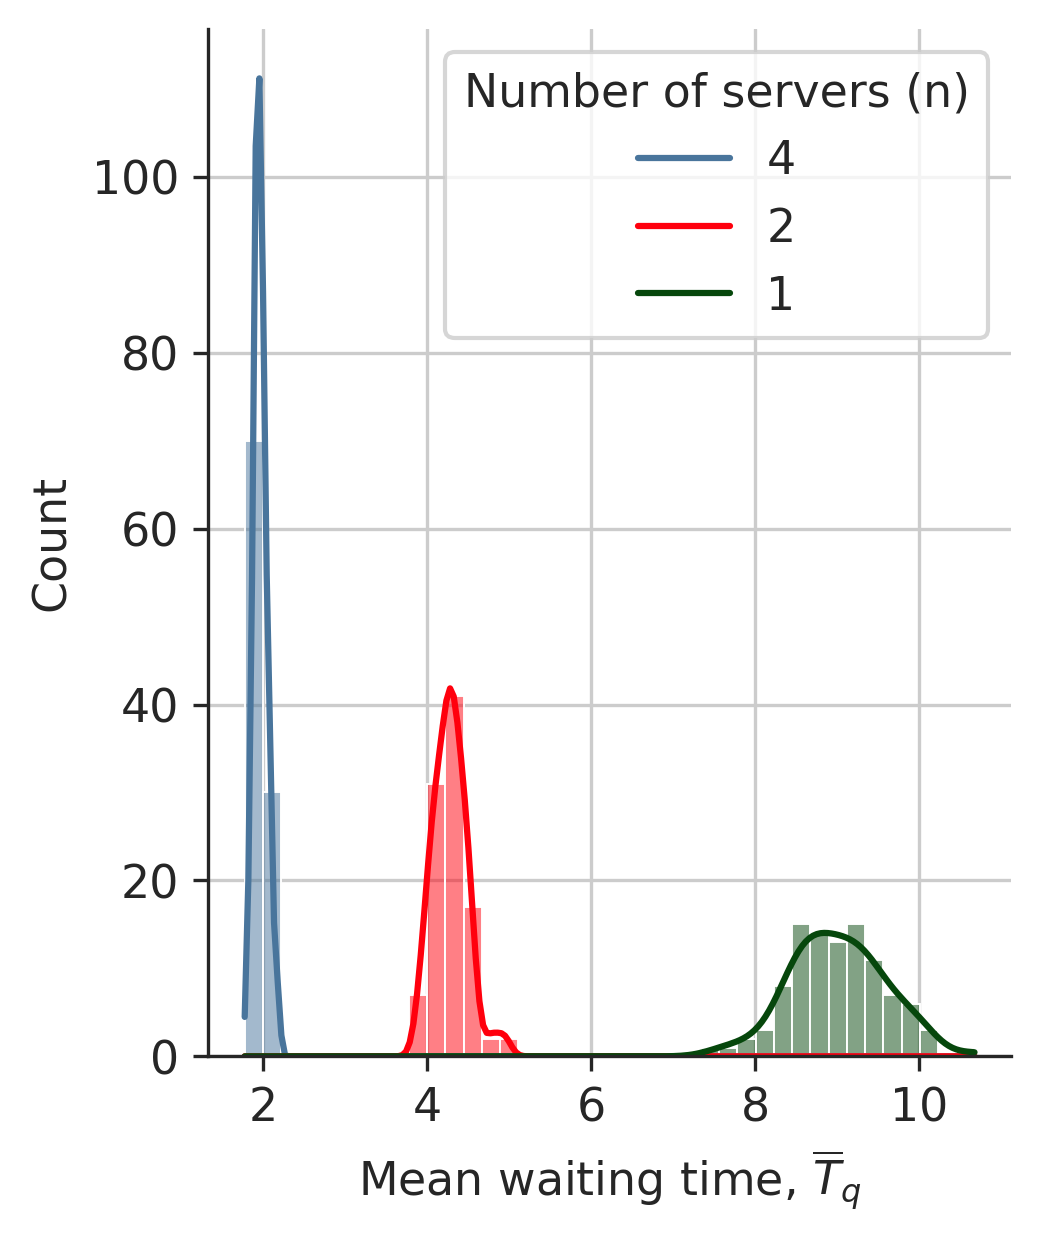

In [11]:
histogram_plotter(simulation_data = "waiting_times_fullsave_124.npz", title = "fullsize_Markovian_histogram.pdf")

In [12]:
def boxplot_plotter(simulation_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot for M/M/n queues
    
    Returns pair-wise F-test with Bonferroni correction and 
    corresponding t-test results for M/M/n queues
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    
    
    # F-test and Welch/T-test for Markovian queues

    
    if simulation_data == "waiting_times_fullsave_124.npz":
        
        # pair-wise F-test: 
    
        heading_length = 80
    
        def _heading(text):
            return dashed_heading(text, heading_length)
    
        print(_heading("Pair-wise F-tests"))

        corrected_p = 0.05 / 3 # bonferroni correction

        print("Corrected critical value (Bonferroni correction) is:", corrected_p)
        
        # 1. M/M/1 vs M/M/2:
        f1, p1 = f_test(data[0], data[1])

        if p1 < corrected_p:
            print(_heading("M/M/1 vs M/M/2"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/1 equals to variance of M/M/2")
            print("F-test statistic is:", f1, " and  p-value is:", p1)
            conclusion1 = "Null Hypothesis is rejected."

        else:
            print(_heading("M/M/1 vs M/M/2"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/1 equals to variance of M/M/2")
            print("F-test statistic is:", f1, " and  p-value is:", p1)
            conclusion1 = "Failed to reject the null hypothesis."

        print(conclusion1)

    
        # 2.  M/M/1 vs  M/M/4:
        f2, p2 = f_test(data[0], data[2])

        if p2 < corrected_p:
            print(_heading("M/M/1 vs  M/M/4"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/1 equals to variance of M/M/4")
            print("F-test statistic is:", f2, " and  p-value is:", p2)
            conclusion2 = "Null Hypothesis is rejected."

        else:
            print(_heading("M/M/1 vs  M/M/4"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/1 equals to variance of M/M/4")
            print("F-test statistic is:", f2, " and  p-value is:", p2)
            conclusion2 = "Failed to reject the null hypothesis."

        print(conclusion2)
        
        # 3.  M/M/2 vs  M/M/4:
        f3, p3 = f_test(data[1], data[2])

        if p3 < corrected_p:
            print(_heading("M/M/2 vs  M/M/4"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/2 equals to variance of M/M/4")
            print("F-test statistic is:", f3, " and  p-value is:", p3)
            conclusion3 = "Null Hypothesis is rejected."

        else:
            print(_heading("M/M/1 vs  M/M/4"))
            print(_heading("TEST STATISTICS"))
            print("H0: Variance of M/M/1 equals to variance of M/M/4")
            print("F-test statistic is:", f3, " and  p-value is:", p3)
            conclusion3 = "Failed to reject the null hypothesis."

        print(conclusion3)
        

        if conclusion1 == "Null Hypothesis is rejected.":
            print(_heading("Welch-test: M/M/1 and M/M/2"))
            res1 = stats.ttest_ind(data[0], data[1], equal_var = False)
        else:
            print(_heading("T-test: M/M/1 and M/M/2"))
            res1 = stats.ttest_ind(data[0], data[1], equal_var = True)
        print(res1)
        
        if conclusion2 == "Null Hypothesis is rejected.":
            print(_heading("Welch-test: M/M/1 and M/M/4"))
            res2 = stats.ttest_ind(data[0], data[2], equal_var = False)
        else:
            print(_heading("T-test: M/M/1 and M/M/4"))
            res2 = stats.ttest_ind(data[0], data[2], equal_var = True)
        print(res2)
            
            
        if conclusion3 == "Null Hypothesis is rejected.":
            print(_heading("Welch-test: M/M/2 and M/M/4"))
            res3 = stats.ttest_ind(data[1], data[2], equal_var = False)
        
        else:
            print(_heading("T-test: M/M/1 and M/M/4"))
            res3 = stats.ttest_ind(data[1], data[2], equal_var = True)
        print(res3)
        
        
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])
    
    df = pd.DataFrame(np.transpose(data), columns = ["1", "2", "4"])
    
    plt.figure(figsize=(4,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.6, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Number of servers, n")
    plt.ylabel(r"Mean waiting time, $\overline{T}_q$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

-------------------------------Pair-wise F-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
---------------------------------M/M/1 vs M/M/2---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/1 equals to variance of M/M/2
F-test statistic is: 7.836830012782775  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/M/1 vs  M/M/4---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/1 equals to variance of M/M/4
F-test statistic is: 54.460732130295476  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/M/2 vs  M/M/4---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/2 equals to variance

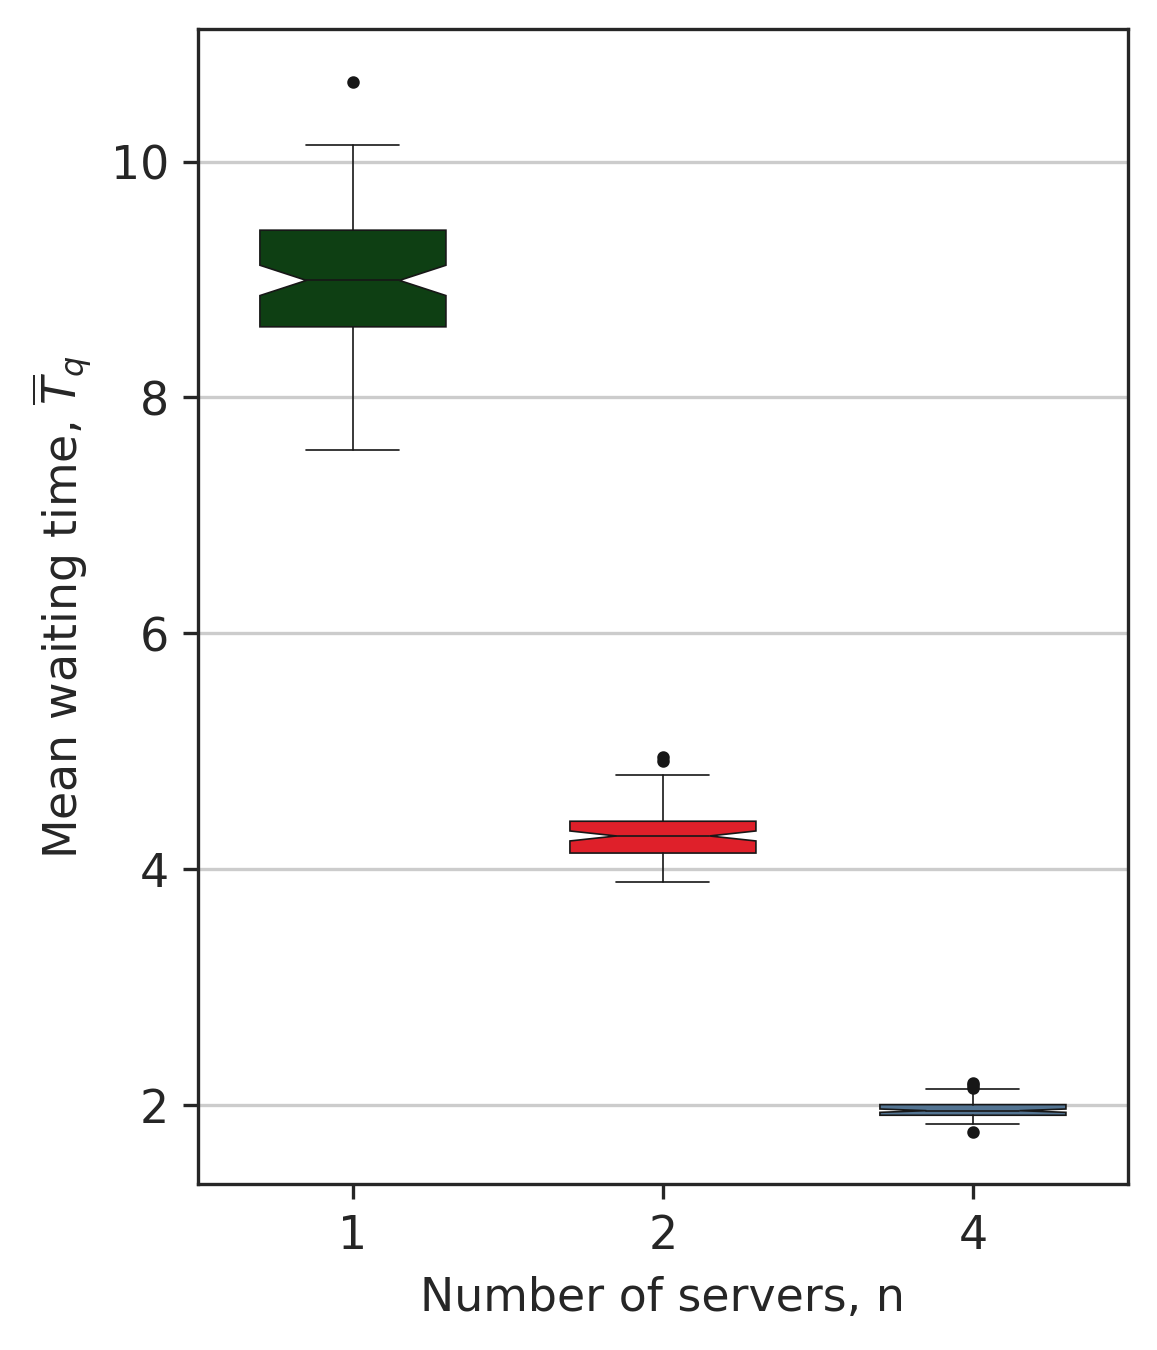

In [13]:
boxplot_plotter(simulation_data = "waiting_times_fullsave_124.npz", title = "Markovian_boxplot.pdf")

In [14]:
"""
Simulation 2: M/M/1 SPTF, 100 runs.
"""

random.seed(0xc0ffee)
SIM_TIME = 10**5
μ = 1.0
ρ = 0.9
number_of_runs = 100
λ = ρ * μ

waiting_times = np.zeros(number_of_runs)

server_count = 1
service_t_dist = exp_factory(μ)
interarrival_t_dist = exp_factory(λ)

filename = "waiting_times_MM1_sptf.npz"
filepath = savepath(filename)

if not exists(filepath):
    for run in range(number_of_runs):
        if run % 5 == 0:
            print(f"{run} of {number_of_runs} done")
        env = simpy.Environment()
        system = System(env, server_count, service_t_dist, sptf = True)
        system.env.process(sim_setup(system, interarrival_t_dist))
        system.env.run(until = SIM_TIME)
        waiting_times[run] = np.mean(system.ts_waiting)
    print("done with all runs")
        
    np.savez(filepath, waiting_times)
    
else:
    save_data = np.load(filepath)
    waiting_times = save_data['arr_0']

In [15]:
def SPTF_FIFO_histogram_plotter(FIFO_data, SPTF_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot` for M/M/1 queue with SPTF and FIFO scheduling
    
    Returns mean waiting time and 95% CI
    
    """
    
    FIFO = np.load(savepath(FIFO_data))['arr_0']
    
    SPTF = np.load(savepath(SPTF_data))['arr_0']

    MM1_FIFO = FIFO[0]
    
    n = 100

    mean_FIFO, variance_FIFO = sample_mean_variance(MM1_FIFO)
    conf_95_FIFO = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_FIFO)/np.sqrt(n)
    
    mean_SPTF, variance_SPTF = sample_mean_variance(SPTF)
    conf_95_SPTF = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_SPTF)/np.sqrt(n)
    
    
    print("Mean waiting time ± CI (95%) for M/M/1 FIFO queue: {0:4f} ± {1:4f}".format(mean_FIFO, conf_95_FIFO))
    
    print("Mean waiting time ± CI (95%) for M/M/1 SPTF queue: {0:4f} ± {1:4f}".format(mean_SPTF, conf_95_SPTF))
    
    
    df = pd.DataFrame({'FIFO': MM1_FIFO, 'SPTF': SPTF})

    
    palette = sns.xkcd_palette(['forest green', 'faded orange'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
    fig = sns.displot(df, bins = 30, kde = True, legend = False, palette=palette, height=4, aspect=0.9) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $\overline{T}_q$")
    
    plt.legend(loc = 1, title = "Scheduling discipline", labels= ["SPTF", "FIFO"])
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()

Mean waiting time ± CI (95%) for M/M/1 FIFO queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for M/M/1 SPTF queue: 3.202565 ± 0.025121


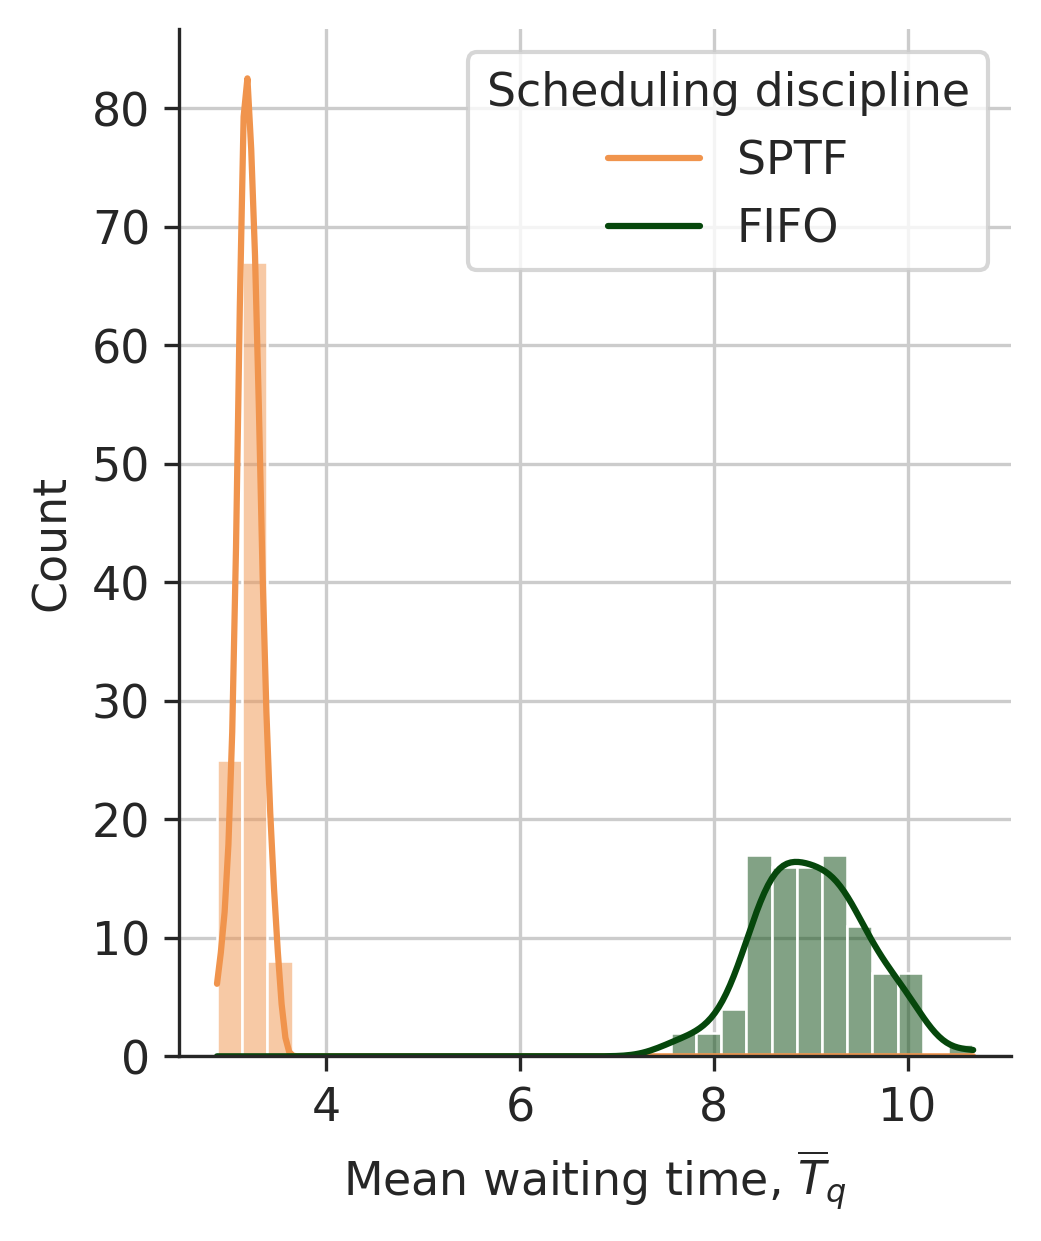

In [16]:
SPTF_FIFO_histogram_plotter(FIFO_data = "waiting_times_fullsave_124.npz", SPTF_data = "waiting_times_MM1_sptf.npz", title = "MM1_FIFO_SPTF_histogram.pdf")

In [17]:
def SPTF_FIFO_boxplot_plotter(FIFO_data, SPTF_data, title):
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot for M/M/1 queue with SPTF and FIFO scheduling
    
    Return F-test and corresponding T-test results
    
    """
    
    FIFO = np.load(savepath(FIFO_data))['arr_0']
    
    MM1_FIFO = FIFO[0]
    
    SPTF = np.load(savepath(SPTF_data))['arr_0']
    
    
    # pair-wise F-test: 
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
    
    print(_heading("F-test"))

    f, p = f_test(MM1_FIFO, SPTF)

    if p < 0.05:
        print(_heading("FIFO vs SPTF"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of FIFO equals to variance of SPTF")
        print("F-test statistic is:", f, " and  p-value is:", p)
        conclusion = "Null Hypothesis is rejected."

    else:
        print(_heading("FIFO vs SPTF"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of FIFO equals to variance of SPTF")
        print("F-test statistic is:", f, " and  p-value is:", p)
        conclusion = "Failed to reject the null hypothesis."

    print(conclusion)
        
    if conclusion == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: FIFO and SPTF"))
        res = stats.ttest_ind(MM1_FIFO, SPTF, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: FIFO and SPTF"))
        res = stats.ttest_ind(MM1_FIFO, SPTF,  alternative = "two-sided", equal_var = True)
    print(res)
    

    df = pd.DataFrame({'FIFO': MM1_FIFO, 'SPTF': SPTF})
        

    palette = sns.xkcd_palette(['forest green', 'faded orange'])
  
    plt.figure(figsize=(4,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.5, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Scheduling discipline")
    plt.ylabel(r"Mean waiting time, $\overline{T}_q$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

-------------------------------------F-test-------------------------------------
----------------------------------FIFO vs SPTF----------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of FIFO equals to variance of SPTF
F-test statistic is: 20.68616266832239  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
---------------------------Welch-test: FIFO and SPTF----------------------------
Ttest_indResult(statistic=98.64033896379462, pvalue=4.505055403710694e-108)


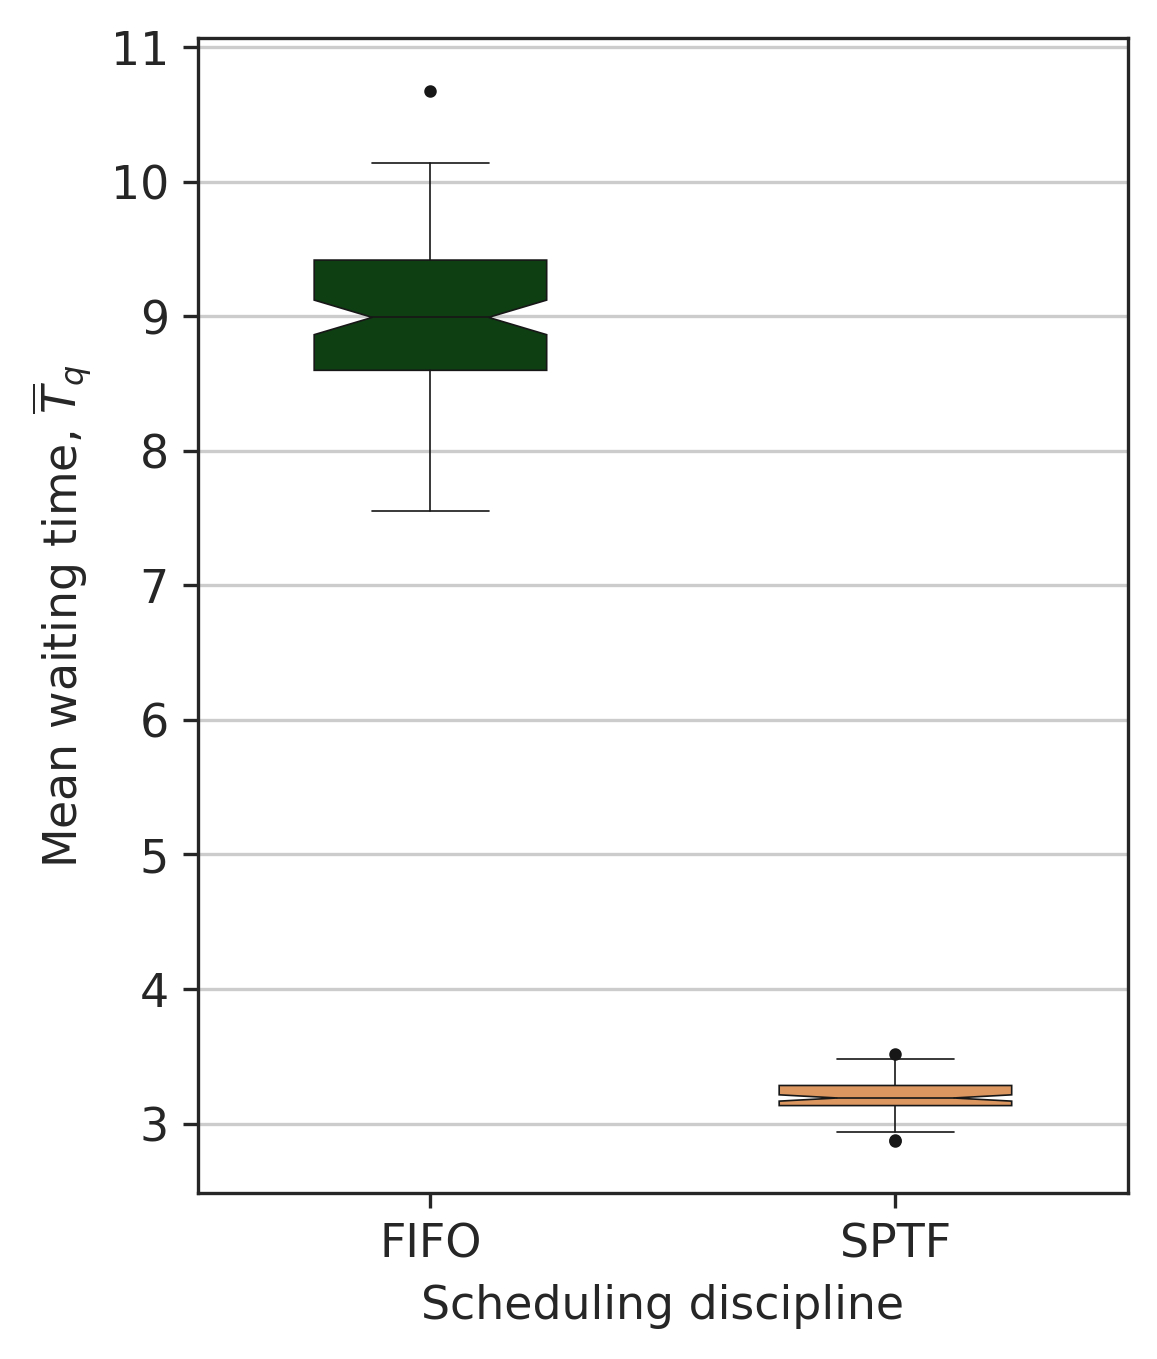

In [18]:
SPTF_FIFO_boxplot_plotter(FIFO_data = "waiting_times_fullsave_124.npz", SPTF_data = "waiting_times_MM1_sptf.npz", title = "MM1_FIFO_SPTF_boxplot.pdf")

In [19]:
"""
Simulation 3: M/D/1, M/D/2, M/D/4, 100 runs.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9
μ = 1.0
λ_values = [μ*ρ*n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = deterministic_factory(1/μ)

filename = "waiting_times_fullsave_124_deterministic.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/D/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting) #waiting time, not sojourn
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

assert len(waiting_times) == len(server_counts)

for wtimes in waiting_times:
    assert len(wtimes) == number_of_runs

In [20]:
"""
M/H/1, M/H/2, M/H/4, 100 runs.

μ = 0.5. (Not used in the report)

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9

μ_hexp = np.array([1.0, 1/5.0])
ps_hexp = np.array([0.75, 0.25])

μ = 1/np.sum(ps_hexp/μ_hexp)

λ_values = [ρ * μ * n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

service_t_dist = hyperexp

filename = "waiting_times_fullsave_124_hyper.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/H/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting)
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']


In [21]:
"""
Simulation 4: M/H/1, M/H/2, M/H/4, 100 runs.

μ = 1.0.

"""

random.seed(0x101ca7)
SIM_TIME = 10**5
server_counts = np.array([1,2,4])

number_of_runs = 100

ρ = 0.9

μs = np.array([2/5, 2/1.0])
ps = np.array([0.25, 0.75])
service_t_dist = hyperexp_factory(μs, ps)

μ = 1/np.sum(ps/μs)

λ_values = [ρ * μ * n for n in server_counts]

waiting_times = np.zeros((len(server_counts), number_of_runs))

filename = "waiting_times_fullsave_124_hyper_mu_1.npz"
filepath = savepath(filename)

if not exists(filepath):
    for i, n in enumerate(server_counts):
        print(f"===M/H/{n}===")
        for run in range(number_of_runs):
            if run % 10 == 0:
                print(f"Done with {run} out of {number_of_runs} runs")
            λ = λ_values[i]
            interarrival_t_dist = exp_factory(λ)
            
            env = simpy.Environment()
            system = System(env, n, service_t_dist)
            
            system.env.process(sim_setup(system, interarrival_t_dist))
            system.env.run(until = SIM_TIME)
            waiting_times[i][run] = np.mean(system.ts_waiting)
    
    np.savez(filepath, waiting_times)
else:
    _save_data = np.load(filepath)
    waiting_times = _save_data['arr_0']

In [22]:
def narrow_histogram_plotter(simulation_data, title):
    
    """
    Plots histogram and distribution from the simulation data
    using seaborn `displot` in a narrow format
    
    Used for plotting results of M/D/n and M/H/n queues.
    
    Returns mean waiting time and 95% CI
    
    """
    
    filename = simulation_data
    filepath = savepath(filename)
    
    data = np.load(filepath)['arr_0']
    n = 100

    mean_1, variance_1 = sample_mean_variance(data[0])
    conf_95_1 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_1)/np.sqrt(n)
    
    mean_2, variance_2 = sample_mean_variance(data[1])
    conf_95_2 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_2)/np.sqrt(n)
    
    mean_4, variance_4 = sample_mean_variance(data[2])
    conf_95_4 = stats.t.ppf(q = 1 - 0.05/2, df=n-1) * np.sqrt(variance_4)/np.sqrt(n)
    
    print("Mean waiting time ± CI (95%) for 1-server queue: {0:4f} ± {1:4f}".format(mean_1, conf_95_1))
    
    print("Mean waiting time ± CI (95%) for 2-server queue: {0:4f} ± {1:4f}".format(mean_2, conf_95_2))
    
    print("Mean waiting time ± CI (95%) for 4-server queue: {0:4f} ± {1:4f}".format(mean_4, conf_95_4))

    df = pd.DataFrame((data), index=["1", "2", "4"])
    
    df_t = df.T
    
    palette = sns.xkcd_palette(['forest green', 'bright red', 'dull blue'])

    sns.set_style("ticks", 
                  {"xtick.major.size":8, "ytick.major.size":8, 'axes.grid': True})
    
#     sns.axes_style("whitegrid")
    fig = sns.displot(df_t, bins = 50, legend = False, kde = True, line_kws={"linewidth":0.6}, palette=palette, height=2, aspect=3) #husl"CMRmap_r"
    
    plt.xlabel(r"Mean waiting time, $ \overline{T}_q $")
    
    plt.legend(loc = 1, title = "Number of servers, n", labels= ["4", "2", "1"])
    #plt.xlim(0.4, 20.0)
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    
    plt.show()



Mean waiting time ± CI (95%) for 1-server queue: 9.018165 ± 0.114256
Mean waiting time ± CI (95%) for 2-server queue: 4.282069 ± 0.040814
Mean waiting time ± CI (95%) for 4-server queue: 1.964095 ± 0.015482


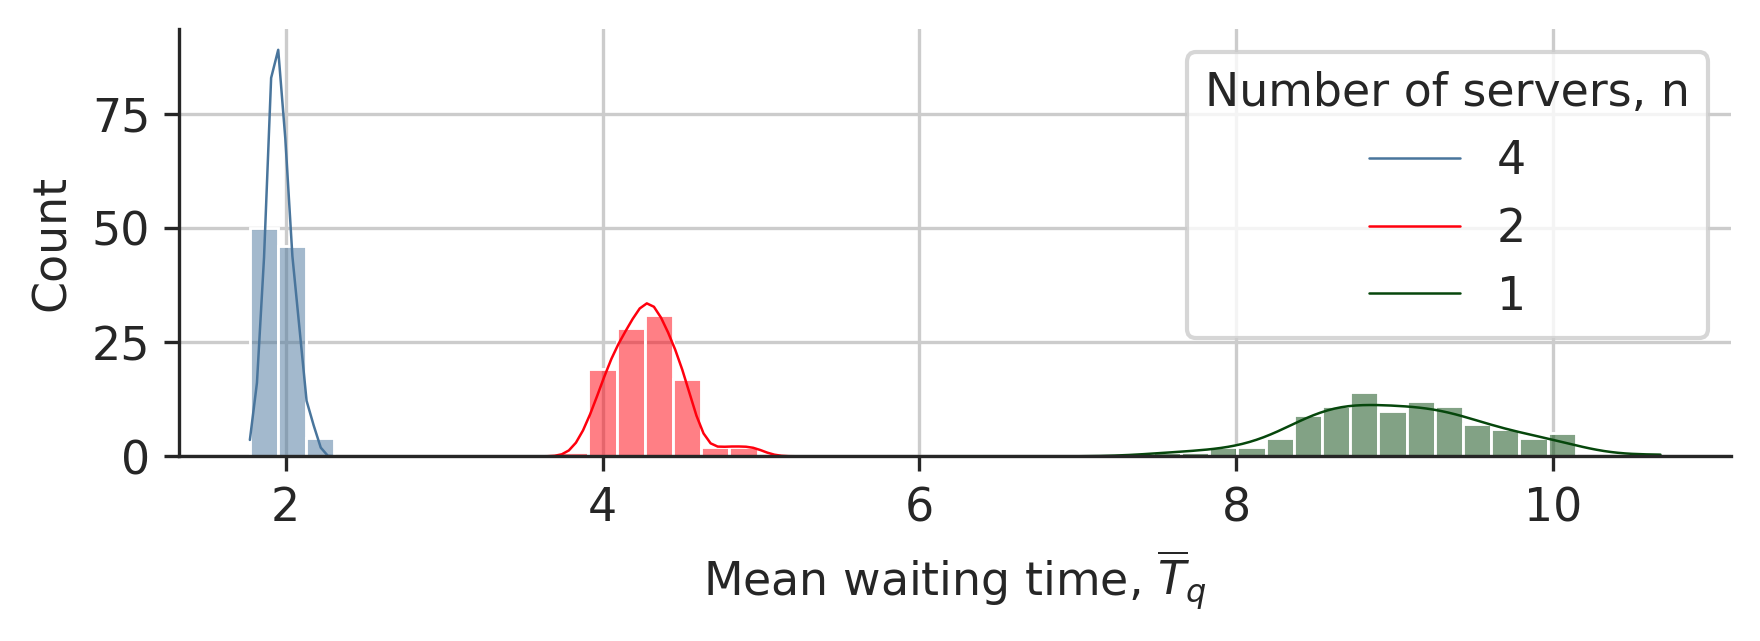

In [23]:
narrow_histogram_plotter("waiting_times_fullsave_124.npz", "Markovian_histogram.pdf")

Mean waiting time ± CI (95%) for 1-server queue: 4.500179 ± 0.041207
Mean waiting time ± CI (95%) for 2-server queue: 2.158022 ± 0.016360
Mean waiting time ± CI (95%) for 4-server queue: 1.002422 ± 0.005325


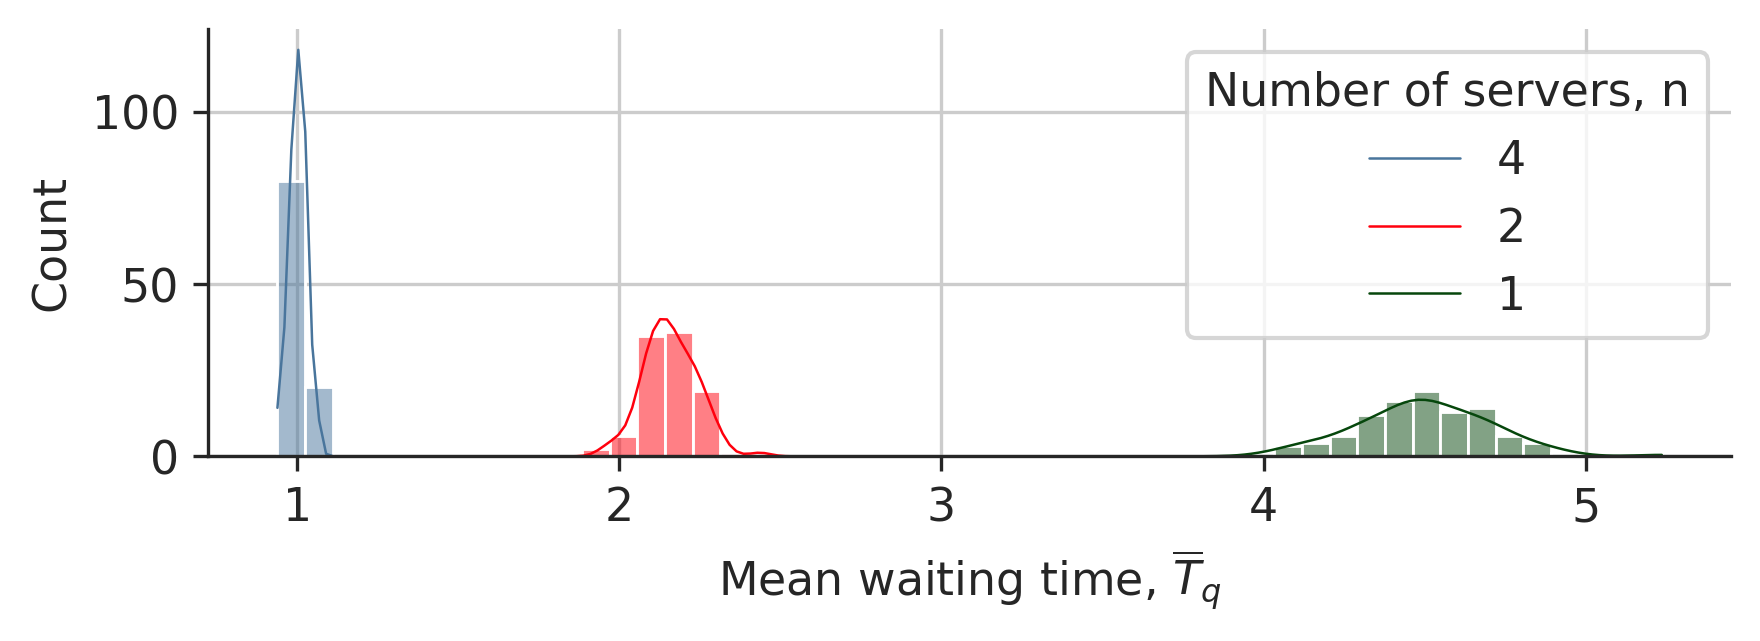

In [24]:
narrow_histogram_plotter("waiting_times_fullsave_124_deterministic.npz", "MD124_histogram.pdf")

Mean waiting time ± CI (95%) for 1-server queue: 15.616397 ± 0.280688
Mean waiting time ± CI (95%) for 2-server queue: 7.396817 ± 0.100719
Mean waiting time ± CI (95%) for 4-server queue: 3.363589 ± 0.037020


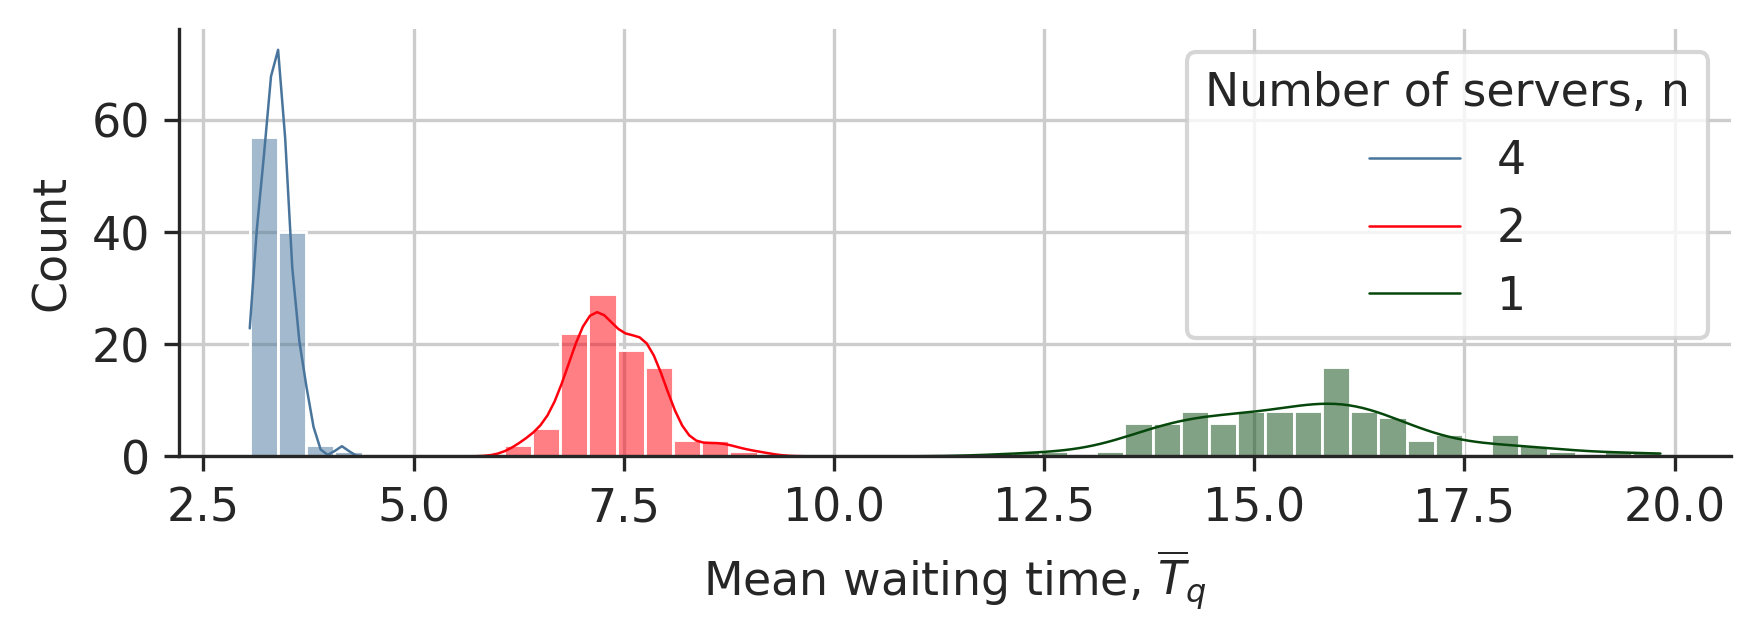

In [25]:
narrow_histogram_plotter("waiting_times_fullsave_124_hyper_mu_1.npz", "MH124_histogram.pdf")

In [26]:
def different_service_time_dist_one_server_plotter(MM_data, MD_data, MH_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot.
    
    Used for plotting M/M/1, M/D/1 and M/H/1 queues.
    
    Return pairwise F-test with Bonferroni correction 
    and corresponding T-test results.
    
    """
    
    MM = np.load(savepath(MM_data))['arr_0']
    
    MM1 = MM[0]
    
    MD = np.load(savepath(MD_data))['arr_0']
    
    MD1 = MD[0]
    
    MH = np.load(savepath(MH_data))['arr_0']
    
    MH1 = MH[0]
    
    df = pd.DataFrame({'M/M/1': MM1, 'M/D/1': MD1, 'M/H/1': MH1})
    
    
     # F-test and Welch/T-test for queues with one server

        
    # pair-wise F-test: 
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
    
    print(_heading("Pair-wise F-tests"))

    corrected_p = 0.05 / 3 # bonferroni correction

    print("Corrected critical value (Bonferroni correction) is:", corrected_p)
        
    # 1. M/M/1 vs M/D/1:
    f1, p1 = f_test(MM1, MD1)

    if p1 < corrected_p:
        print(_heading("M/M/1 vs M/D/1:"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/1 equals to variance of M/D/1")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/M/1 vs M/D/1"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/1 equals to variance of M/D/1")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Failed to reject the null hypothesis."

    print(conclusion1)

    
    # 2.  M/M/1 vs  M/H/1:
    f2, p2 = f_test(MH1, MM1)

    if p2 < corrected_p:
        print(_heading("M/M/1 vs  M/H/1"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/1 equals to variance of M/H/1")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("M/M/1 vs  M/H/1"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/1 equals to variance of M/H/1")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Failed to reject the null hypothesis."

    print(conclusion2)
        
    # 3.  M/D/1 vs  M/H/1:
    f3, p3 = f_test(MH1, MD1)

    if p3 < corrected_p:
        print(_heading("M/D/1 vs  M/H/1"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/1 equals to variance of M/H/1")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/D/1 vs  M/H/1"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/1 equals to variance of M/H/1")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Failed to reject the null hypothesis."

    print(conclusion3)
        

    if conclusion1 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/1 and M/D/1"))
        res1 = stats.ttest_ind(MM1, MD1, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/1 and M/D/1"))
        res1 = stats.ttest_ind(MM1, MD1, alternative = "two-sided", equal_var = True)
    print(res1)
        
    if conclusion2 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/1 and M/H/1"))
        res2 = stats.ttest_ind(MM1, MH1, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/1 and M/H/1"))
        res2 = stats.ttest_ind(MM1, MH1, alternative = "two-sided", equal_var = True)
    print(res2)
            
            
    if conclusion3 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/D/1 and M/H/1"))
        res3 = stats.ttest_ind(MD1, MH1, alternative = "two-sided", equal_var = False)
        
    else:
        print(_heading("T-test: M/D/1 and M/H/1"))
        res3 = stats.ttest_ind(MD1, MH1, alternative = "two-sided", equal_var = True)
    print(res3)
    

    
        

    palette = sns.xkcd_palette(['forest green', 'lime', 'faded green'])
  
    plt.figure(figsize=(3,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.7, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Queues")
    plt.ylabel(r"Mean waiting time, $\overline{T}_q$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

-------------------------------Pair-wise F-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
--------------------------------M/M/1 vs M/D/1:---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/1 equals to variance of M/D/1
F-test statistic is: 7.688111693444788  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/M/1 vs  M/H/1---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/1 equals to variance of M/H/1
F-test statistic is: 6.035208104894747  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/D/1 vs  M/H/1---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/D/1 equals to variance 

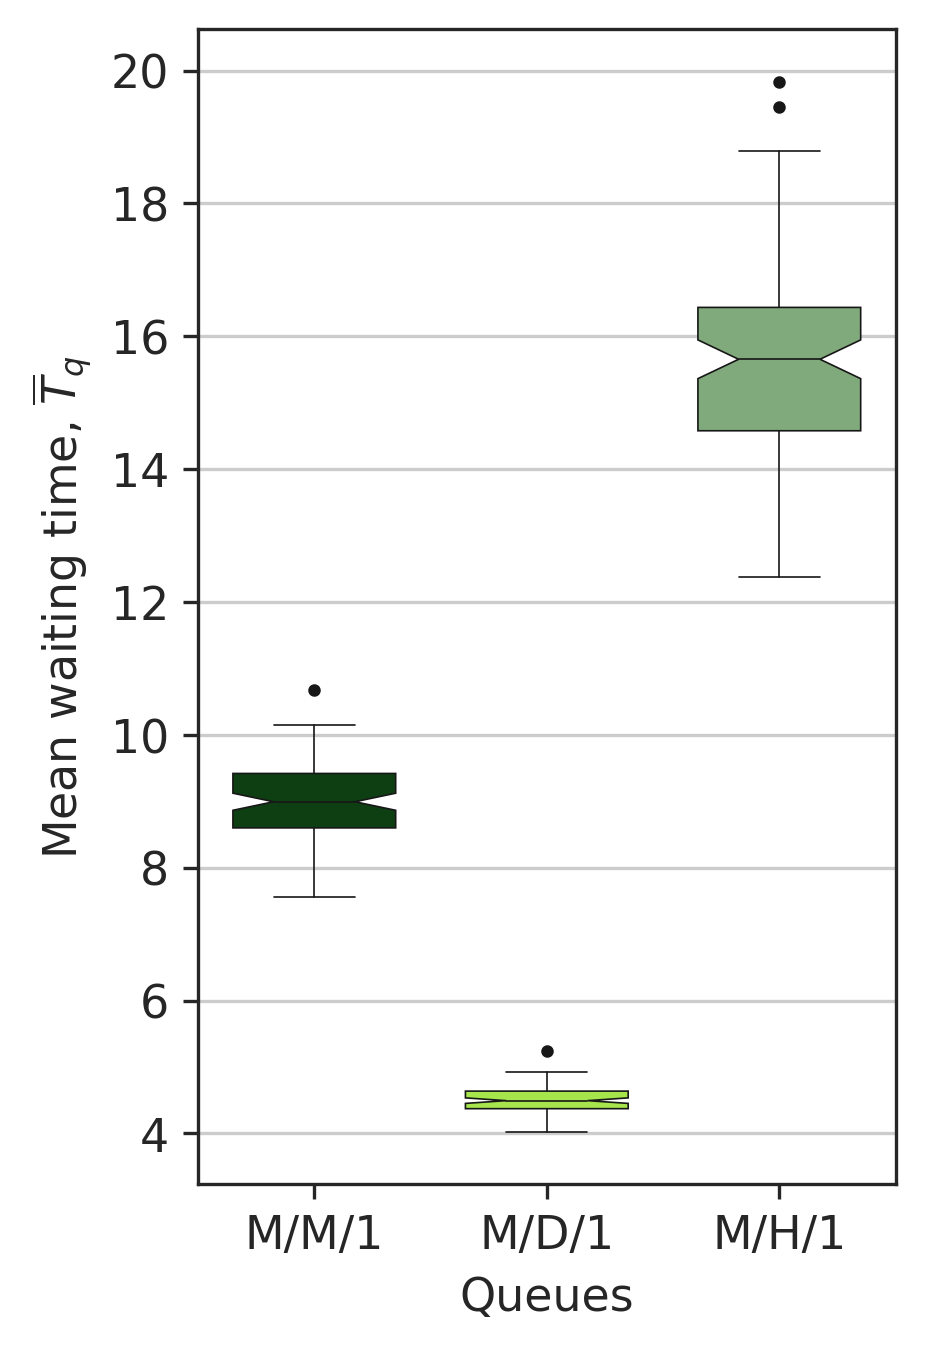

In [27]:
different_service_time_dist_one_server_plotter(MM_data = "waiting_times_fullsave_124.npz", MD_data = "waiting_times_fullsave_124_deterministic.npz", MH_data = "waiting_times_fullsave_124_hyper_mu_1.npz", title ="One_server_different_B.pdf")

In [28]:
def different_service_time_dist_two_servers_plotter(MM_data, MD_data, MH_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot.
    
    Used for plotting M/M/2, M/D/2 and M/H/2 queues.
    
    Return pairwise F-test with Bonferroni correction 
    and corresponding T-test results.
    
    """
    
    MM = np.load(savepath(MM_data))['arr_0']
    
    MM2 = MM[1]
    
    MD = np.load(savepath(MD_data))['arr_0']
    
    MD2 = MD[1]
    
    MH = np.load(savepath(MH_data))['arr_0']
    
    MH2 = MH[1]
    
    df = pd.DataFrame({'M/M/2': MM2, 'M/D/2': MD2, 'M/H/2': MH2})
    
    
     # F-test and Welch/T-test for queues with one server

        
    # pair-wise F-test: 
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
    
    print(_heading("Pair-wise F-tests"))

    corrected_p = 0.05 / 3 # bonferroni correction

    print("Corrected critical value (Bonferroni correction) is:", corrected_p)
        
    # 1. M/M/2 vs M/D/2:
    f1, p1 = f_test(MM2, MD2)

    if p1 < corrected_p:
        print(_heading("M/M/2 vs M/D/2:"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/2 equals to variance of M/D/2")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/M/2 vs M/D/2"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/2 equals to variance of M/D/2")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Failed to reject the null hypothesis."

    print(conclusion1)

    
    # 2.  M/M/2 vs  M/H/2:
    f2, p2 = f_test(MH2, MM2)

    if p2 < corrected_p:
        print(_heading("M/M/2 vs  M/H/2"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/2 equals to variance of M/H/2")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("M/M/2 vs  M/H/2"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/2 equals to variance of M/H/2")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Failed to reject the null hypothesis."

    print(conclusion2)
        
    # 3.  M/D/2 vs  M/H/2:
    f3, p3 = f_test(MH2, MD2)

    if p3 < corrected_p:
        print(_heading("M/D/2 vs  M/H/2"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/2 equals to variance of M/H/2")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/D/2 vs  M/H/2"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/2 equals to variance of M/H/2")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Failed to reject the null hypothesis."

    print(conclusion3)
        

    if conclusion1 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/2 and M/D/2"))
        res1 = stats.ttest_ind(MM2, MD2, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/2 and M/D/2"))
        res1 = stats.ttest_ind(MM2, MD2, alternative = "two-sided", equal_var = True)
    print(res1)
        
    if conclusion2 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/2 and M/H/2"))
        res2 = stats.ttest_ind(MM2, MH2, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/1 and M/H/1"))
        res2 = stats.ttest_ind(MM2, MH2, alternative = "two-sided", equal_var = True)
    print(res2)
            
            
    if conclusion3 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/D/2 and M/H/2"))
        res3 = stats.ttest_ind(MD2, MH2, alternative = "two-sided", equal_var = False)
        
    else:
        print(_heading("T-test: M/D/2 and M/H/2"))
        res3 = stats.ttest_ind(MD2, MH2, alternative = "two-sided", equal_var = True)
    print(res3)
    

    
        

    palette = sns.xkcd_palette(['bright red', 'reddish', 'wine red'])
  
    plt.figure(figsize=(3,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.7, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Queues")
    plt.ylabel(r"Mean waiting time, $\overline{T}_q$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

-------------------------------Pair-wise F-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
--------------------------------M/M/2 vs M/D/2:---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/2 equals to variance of M/D/2
F-test statistic is: 6.223365069453569  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/M/2 vs  M/H/2---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/2 equals to variance of M/H/2
F-test statistic is: 6.089869400296425  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/D/2 vs  M/H/2---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/D/2 equals to variance 

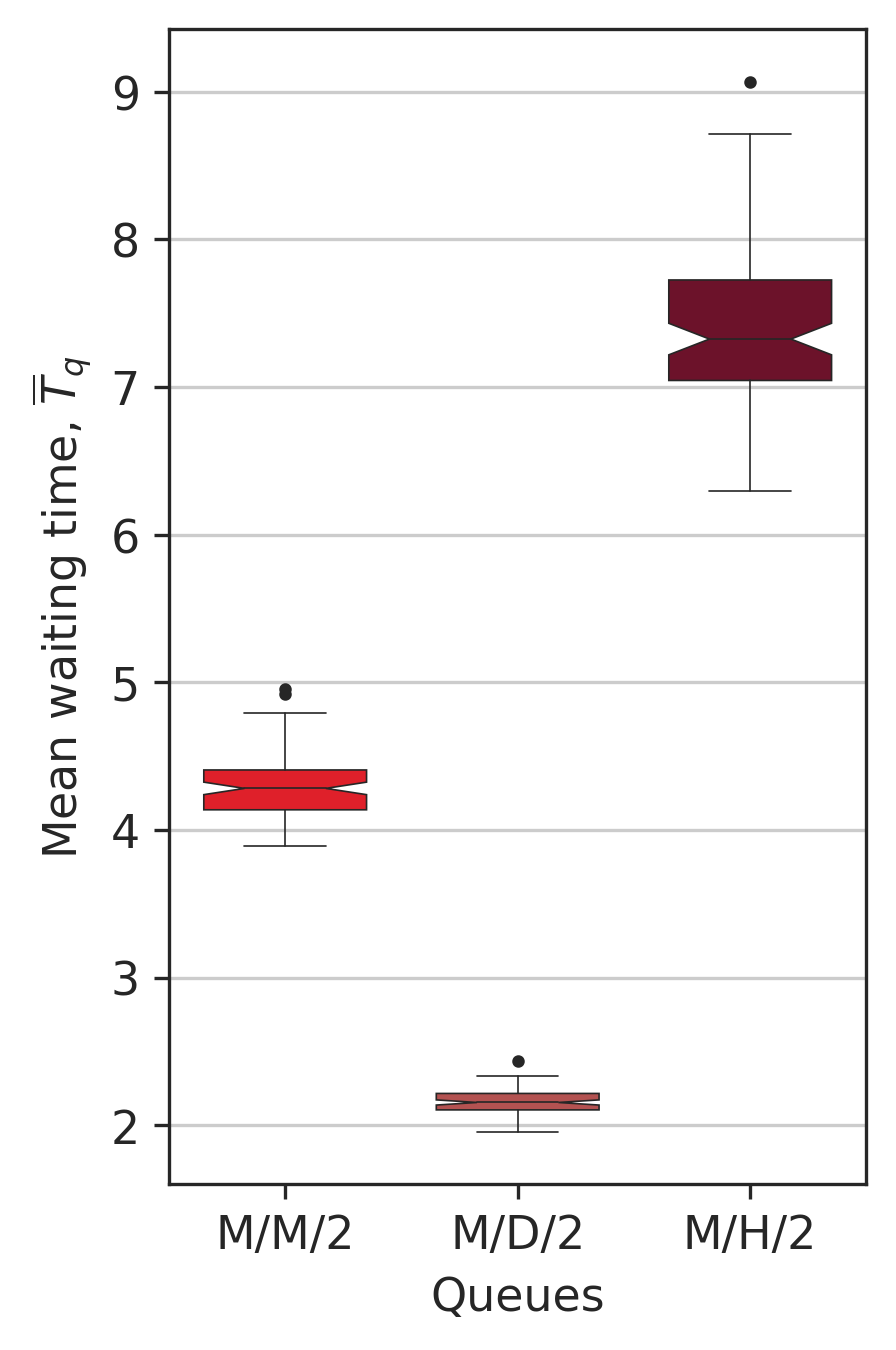

In [29]:
different_service_time_dist_two_servers_plotter(MM_data = "waiting_times_fullsave_124.npz", MD_data = "waiting_times_fullsave_124_deterministic.npz", MH_data = "waiting_times_fullsave_124_hyper_mu_1.npz", title ="Two_servers_different_B.pdf")

In [30]:
def different_service_time_dist_four_servers_plotter(MM_data, MD_data, MH_data, title):
    
    """
    Plots boxplot from simualation data 
    using seaborn's boxplot.
    
    Used for plotting M/M/4, M/D/4 and M/H/4 queues.
    
    Return pairwise F-test with Bonferroni correction 
    and corresponding T-test results.
    
    """
    
    MM = np.load(savepath(MM_data))['arr_0']
    
    MM4 = MM[2]
    
    MD = np.load(savepath(MD_data))['arr_0']
    
    MD4 = MD[2]
    
    MH = np.load(savepath(MH_data))['arr_0']
    
    MH4 = MH[2]
    
    df = pd.DataFrame({'M/M/4': MM4, 'M/D/4': MD4, 'M/H/4': MH4})
    
    
     # F-test and Welch/T-test for queues with one server

        
    # pair-wise F-test: 
    
    heading_length = 80
    
    def _heading(text):
        return dashed_heading(text, heading_length)
    
    print(_heading("Pair-wise F-tests"))

    corrected_p = 0.05 / 3 # bonferroni correction

    print("Corrected critical value (Bonferroni correction) is:", corrected_p)
        
    # 1. M/M/4 vs M/D/4:
    f1, p1 = f_test(MM4, MD4)

    if p1 < corrected_p:
        print(_heading("M/M/4 vs M/D/4:"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/4 equals to variance of M/D/4")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/M/4 vs M/D/4"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/4 equals to variance of M/D/4")
        print("F-test statistic is:", f1, " and  p-value is:", p1)
        conclusion1 = "Failed to reject the null hypothesis."

    print(conclusion1)

    
    # 2.  M/M/4 vs  M/H/4:
    f2, p2 = f_test(MH4, MM4)

    if p2 < corrected_p:
        print(_heading("M/M/4 vs  M/H/4"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/4 equals to variance of M/H/4")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Null Hypothesis is rejected."
        
    else:
        print(_heading("M/M/4 vs  M/H/4"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/M/4 equals to variance of M/H/4")
        print("F-test statistic is:", f2, " and  p-value is:", p2)
        conclusion2 = "Failed to reject the null hypothesis."

    print(conclusion2)
        
    # 3.  M/D/4 vs  M/H/4:
    f3, p3 = f_test(MH4, MD4)

    if p3 < corrected_p:
        print(_heading("M/D/4 vs  M/H/4"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/4 equals to variance of M/H/4")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Null Hypothesis is rejected."

    else:
        print(_heading("M/D/4 vs  M/H/4"))
        print(_heading("TEST STATISTICS"))
        print("H0: Variance of M/D/4 equals to variance of M/H/4")
        print("F-test statistic is:", f3, " and  p-value is:", p3)
        conclusion3 = "Failed to reject the null hypothesis."

    print(conclusion3)
        

    if conclusion1 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/4 and M/D/4"))
        res1 = stats.ttest_ind(MM4, MD4, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/4 and M/D/4"))
        res1 = stats.ttest_ind(MM4, MD4, alternative = "two-sided", equal_var = True)
    print(res1)
        
    if conclusion2 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/M/4 and M/H/4"))
        res2 = stats.ttest_ind(MM4, MH4, alternative = "two-sided", equal_var = False)
    else:
        print(_heading("T-test: M/M/1 and M/H/1"))
        res2 = stats.ttest_ind(MM4, MH4, alternative = "two-sided", equal_var = True)
    print(res2)
            
            
    if conclusion3 == "Null Hypothesis is rejected.":
        print(_heading("Welch-test: M/D/4 and M/H/4"))
        res3 = stats.ttest_ind(MD4, MH4, alternative = "two-sided", equal_var = False)
        
    else:
        print(_heading("T-test: M/D/4 and M/H/4"))
        res3 = stats.ttest_ind(MD4, MH4, alternative = "two-sided", equal_var = True)
    print(res3)
    

    
        

    palette = sns.xkcd_palette(['dull blue', 'bright sky blue', 'warm blue'])
  
    plt.figure(figsize=(3,5))
    fig = sns.boxplot(data=df, palette=palette, notch=True, linewidth=0.4, 
                 fliersize=2, width = 0.7, flierprops=dict(marker='o', markersize=2))
    
    plt.xlabel("Queues")
    plt.ylabel(r"Mean waiting time, $\overline{T}_q$")
    title = plot_savepath(title)
    plt.savefig(title, bbox_inches = 'tight')
    plt.show()

-------------------------------Pair-wise F-tests--------------------------------
Corrected critical value (Bonferroni correction) is: 0.016666666666666666
--------------------------------M/M/4 vs M/D/4:---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/4 equals to variance of M/D/4
F-test statistic is: 8.451849477852067  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/M/4 vs  M/H/4---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/M/4 equals to variance of M/H/4
F-test statistic is: 5.717498598088074  and  p-value is: 1.1102230246251565e-16
Null Hypothesis is rejected.
--------------------------------M/D/4 vs  M/H/4---------------------------------
--------------------------------TEST STATISTICS---------------------------------
H0: Variance of M/D/4 equals to variance 

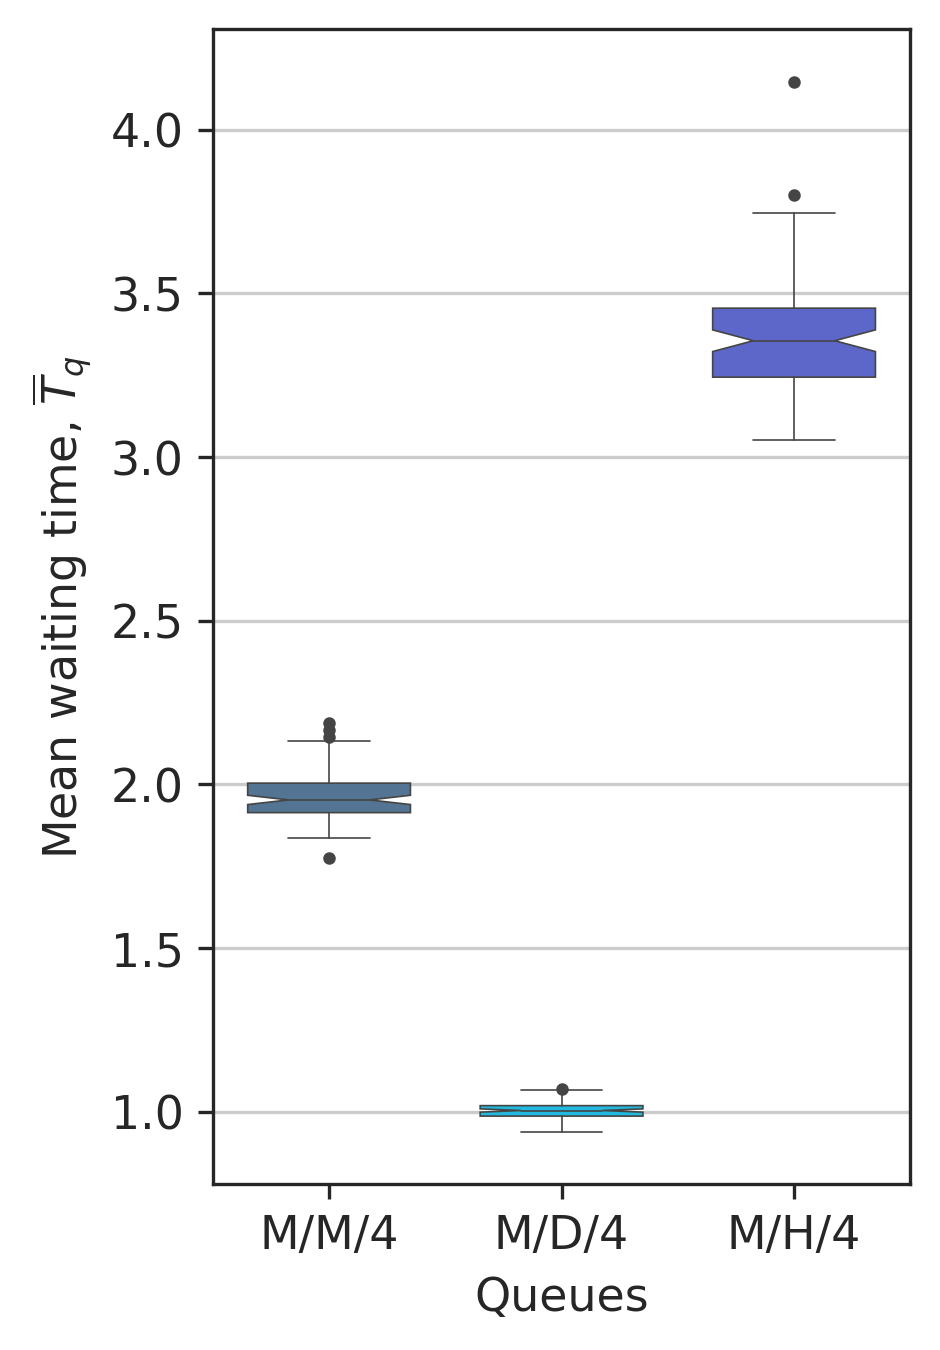

In [31]:
different_service_time_dist_four_servers_plotter(MM_data = "waiting_times_fullsave_124.npz", MD_data = "waiting_times_fullsave_124_deterministic.npz", MH_data = "waiting_times_fullsave_124_hyper_mu_1.npz", title ="Four_servers_different_B.pdf")
